<a href="https://colab.research.google.com/github/menguri/NH_investment/blob/master/%EC%B5%9C%EC%A2%85_%EB%B6%84%EC%84%9D_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 분석 환경 구축

## 1.1 필요한 라이브러리 불러오기

In [ ]:
pip install pandasql

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install kmodes

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install finance-datareader

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandasql import sqldf
import FinanceDataReader as fdr
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from kmodes.kprototypes import KPrototypes
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import shap
import zipfile
import re
import time
import datetime
import requests
from tqdm import tqdm
import math
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family='NanumBarunGothic')

## 1.2 데이터 불러오기

In [ ]:
cus_info = pd.read_csv('/home/public/cus_ifo.csv')
kr_stk = pd.read_csv('/home/public/kr_stk_orr.csv')
oss_stk = pd.read_csv('/home/public/oss_stk_orr.csv')
bnc_data = pd.read_csv('/home/public/cus_itg_sct_bnc.csv')
aet_data = pd.read_csv('/home/public/cus_tot_aet_ifo.csv')

In [ ]:
cus_info = cus_info.rename(columns={'cus_no' :'고객번호',
                          'act_no' : '계좌번호',
                          'bse_ym' : '고객정보기준년월',
                          'cus_gb' : '고객단말구분',
                          'mts_mm_access_type' : 'MTS월단위접속패턴',
                          'sex_dit_cd' : '성별',
                          'cus_age_stn_cd': '연령대',
                          'tco_cus_grd_cd' : '고객등급코드',
                          'cus_aet_stn_cd' : '고객자산구간코드',
                          'pft_amt_stn_cd' : '수익금액구간코드',
                          'fst_act_opn_dt' : '최초계좌개설일',
                          'stk_pdt_hld_yn' : '주식상품보유여부',
                          'ose_stk_pdt_hld_yn' : '해외주식상품보유여부',
                          'mrz_pdt_tp_sgm_cd' : '주거래상품군',
                          'lsg_sgm_cd' : 'LIFESTAGE세그먼트코드',
                          'tot_ivs_te_sgm_cd' : '총투자기간세그먼트코드',
                          'hld_pdt_tp_sgm_cd' : '보유상품유형세그먼트코드',
                          'loy_sgm_cd' : '충성도세그먼트코드',
                          'mrz_mkt_dit_cd' : '주거래시장구분코드',
                          'mrz_btp_dit_cd' : '주거래업종구분코드',
                          'aet_bse_stk_trd_tp_cd' : '자산기준주식거래유형코드',
                          'bas_stk_trd_tp_cd' : '기본주식거래유형코드'
                          })

kr_stk = kr_stk.rename(columns={'act_no' : '계좌번호',
                          'orr_dt' : '주문날짜',
                          'orr_ord' : '주문순서',
                          'orr_rtn_hur' : '주문접수시간대',
                          'lst_cns_hur' : '최종체결시간대',
                          'iem_cd' : '종목코드',
                          'sby_dit_cd' : '매매구분코드',
                          'cns_qty' : '체결건수',
                          'orr_pr' : '체결외화단가',
                          'orr_mdi_dit_cd' : '주문매체구분코드'
                          })

oss_stk = oss_stk.rename(columns={'act_no' : '계좌번호',
                        'orr_dt' : '주문날짜',
                        'orr_ord' : '주문순서',
                        'orr_rtn_hur' : '주문접수시간대',
                        'lst_cns_hur' : '최종체결시간대',
                        'iem_cd' : '종목코드',
                        'sby_dit_cd' : '매매구분코드',
                        'cns_qty' : '체결건수',
                        'orr_pr' : '체결외화단가',
                        'orr_mdi_dit_cd' : '주문매체구분코드',
                        'cur_cd' : '거래통화코드',
                        'trd_cur_xcg_rt' : '거래통화환율'
                        })

aet_data = aet_data.rename(columns={'cus_no' : '고객번호',
                          'act_no' : '계좌번호',
                          'mts_mm_access_type' : 'MTS월단위접속패턴',
                          'tot_aet_tld_rnd_202201' : '2022년1월총자산',
                          'tot_aet_tld_rnd_202202' : '2022년2월총자산',
                          'tot_aet_tld_rnd_202203' : '2022년3월총자산',
                          'tot_aet_tld_rnd_202204' : '2022년4월총자산',
                          'tot_aet_tld_rnd_202205' : '2022년5월총자산',
                          'tot_aet_tld_rnd_202206' : '2022년6월총자산'
                          })

bnc_data = bnc_data.rename(columns={'act_no' : '계좌번호',
                          'bse_ym' : '기준년월',
                          'iem_cd' : '종목코드',
                          'fc_sec_trd_nat_cd' : '외화증권거래국가코드',
                          'itg_pdt_tp_cd' : '통합상품유형코드',
                          'stl_bse_itg_bnc_qty' : '결제기준통합잔고수량',
                          'itg_byn_cns_qty' : '통합매수체결수량',
                          'itg_sll_cns_qty' : '통합매도체결수량',
                          'cns_bse_itg_bnc_qty' : '체결기준통합잔고수량',
                          'stl_bse_now_eal_amt' : '결제기준현재평가금액',
                          'stl_bse_fc_now_eal_amt' : '결제기준외화현재평가금액',
                          'cns_bse_now_eal_amt' : '체결기준현재평가금액',
                          'cns_bse_fc_now_eal_amt' : '체결기준외화현재평가금액',
                          'lon_amt' : '체결기준대출금액',
                          'cur_cd' : '거래통화코드'
                          })

# 2. EDA

## 2.1 EDA 전 데이터 처리

한 명의 고객에 대한 고객 정보는 1월~6월까지 총 6개의 행이 존재하지만, 고객의 성향에 대한 분석을 진행할 것이므로, 가장 최근의 데이터인 6월의 데이터만을 사용하기로 한다. 그 결과 총 10000명의 고객의 6월 데이터만이 남게 되었다.

In [ ]:
cus_info = cus_info[cus_info['고객정보기준년월'] == 202206].copy()
cus_info.drop('고객정보기준년월', axis=1, inplace=True)

또한 연구는 주식상품에 대해서만 진행될 것이므로, 주식상품을 보유하고 있는 고객으로 분석 대상을 한정한다.

In [ ]:
cus_info = cus_info[cus_info['주식상품보유여부'] == 'Y'].reset_index(drop = True)
cus_info.drop('주식상품보유여부', axis = 1, inplace = True)

## 2.2 각 데이터셋 EDA

본 연구에서 주의깊게 봐야하는 부분은 고객충성도 부분이라 할 수 있다. 작은 수일수록 충성도가 높음을 나타내는데, 4와 5에 고객이 모두 몰려있는 것으로 보아 현재 투자증권의 고객들은 그리 높은 충성도를 보이지 않는다고 할 수 있다.   
**고로 이 충성도를 높일 수 있는 고객 맞춤형 큐레이션이 필요하다.**

국내 주식시장의 오픈 시간인 9시에 가장 많은 주문과 체결이 이루어진다. 매도보다 매수가 2배 가까이 일어나며, 대부분 무선 단말기를 사용하여 이루어진다.   
체결건수 열을 주의깊게 살펴보자면, 건수가 거의 0에 가깝다. 이 또한 고객의 활발한 주식 거래를 위한 나은 서비스의 필요성을 시사한다.

해외 주식 거래의 경우 우리나라 시간으로 18시에 오픈이 되는데, 역시 그 시간대에 가장 많은 주문과 거래체결이 일어난다. 매체는 역시 무선단말이 압도적인 비율을 보이고, 매수가 매도의 2배 가까이 일어난다.  
해외주식 또한 체결건수가 낮은 수에 많이 분포해있는 것을 보아 해외주식에 대한 서비스 제공 또한 필요해보인다.

## 2.3 국내거래와 해외거래 

윗줄은 국내 주식에 대한, 아랫줄은 해외 주식에 대한 그래프들이다.  
위아래로 비교를 해보면 그래프의 분포가 확연히 다른 것을 확인할 수 있고,  
**이는 곧 해외주식의 보유 여부 그 자체가 고객의 주식성향을 나타낼 수 있다는 것을 뜻한다.**

## GA데이터와 매수/매도 데이터 간의 연결  
전반적인 절차는  
Step1. 국내와 해외주식 종목코드만을 뽑아내기  
Step2. 종목코드와 계좌번호를 연결시켜 두 데이터 연계하기
이지만, oss_stk에 대해서는 종목이 ISIN코드로 되어있고 GA에 대해서는 ticker로 되어있어서 이 둘을 크롤링하여 연계하는 데에 시간이 오래 걸립니다. 따라서, 이미 만들어놓은 GA_with_ticker 데이터를 로드해오겠습니다. 데이터를 로드해온 후엔 바로 '2.4 GA데이터에 대한 EDA'로 넘어가시면 됩니다.

아래부턴 위의 GA_with_stk_result2.csv를 만드는 과정입니다

**종목코드만을 뽑아내기**  
Step1. 정규표현식으로 종목코드 나타내는 거 만들기  
Step2. 이벤트조치에서 추출해낸 종목코드 열 만들기

**해외주식 ISIN코드 데이터셋 생성**  
해외주식의 경우 매수/매도 데이터엔 ISIN코드로, GA엔 ticker로 들어가 있기 때문에 이를 연결시켜줄 수 있는 사전 생성  
그 후 매수/매도 데이터(oss_stk)에 ISIN코드에 맞는 ticker 열을 새로 생성

**주식 매수/매도 데이터와의 연결**   
Step3. 고객의 계좌번호, 방문일자, 종목코드 기준으로 데이터 병합

## 2.4 GA데이터에 대한 EDA

### 2.4.1 충성도와 주가지수의 연관성

In [ ]:
# 각 월 별 주가지수 데이터 가져오기
df_kospi = fdr.DataReader('KS11','2022')
df_kospi = df_kospi.reset_index()
df_kospi['month'] = df_kospi['Date'].dt.month

df_ks_month = pd.DataFrame(df_kospi.groupby('month')['Close'].mean()).reset_index()
df_ks_month = df_ks_month[:6]
df_ks_month

,month,Close
0,1,2859.066830
1,2,2724.015015
2,3,2698.716192
3,4,2703.242850
4,5,2629.215002
5,6,2474.948486


In [ ]:
# 고객 충성도 정보 가져오기
cus_info2 = pd.read_csv('/home/public/cus_ifo.csv', encoding = 'utf-8')

cus_info2 = cus_info2.astype({'bse_ym':'str'})
cus_info2['month'] = 0

for i in range(len(cus_info2)):
    cus_info2['month'][i] = datetime.strptime(cus_info2['bse_ym'][i], '%Y%m').month

In [ ]:
group_month = pd.DataFrame(cus_info2.groupby(['month', 'loy_sgm_cd'])['cus_no'].count())
group_month = group_month.reset_index()

Text(0.5, 1.0, '최상급 월별 변화 with 코스피 지수')

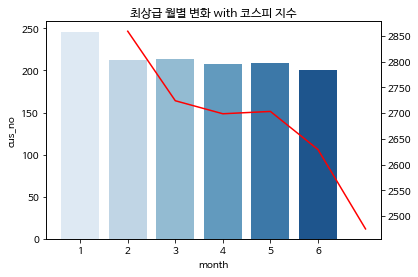

In [ ]:
top = group_month[group_month['loy_sgm_cd'] == 1.0]

fig, ax1 = plt.subplots()
sns.barplot(x = 'month', y = 'cus_no', data = top, palette = 'Blues')

ax2 = ax1.twinx()
ax2.plot(df_ks_month['month'], df_ks_month['Close'], color = 'red', label = '코스피 지수')

plt.title('최상급 월별 변화 with 코스피 지수')

Text(0.5, 1.0, '최하급 월별 변화 with 코스피 지수')

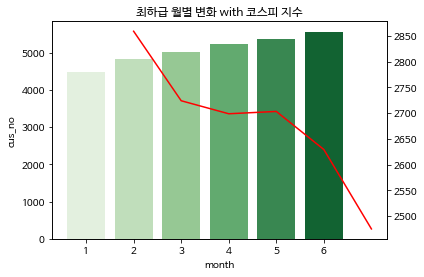

In [ ]:
bottom = group_month[group_month['loy_sgm_cd'] == 5]

fig, ax1 = plt.subplots()
sns.barplot(x = 'month', y = 'cus_no', data = bottom, palette = 'Greens')

ax2 = ax1.twinx()
ax2.plot(df_ks_month['month'], df_ks_month['Close'], color = 'red', label = '코스피 지수')

plt.title('최하급 월별 변화 with 코스피 지수')

최상급의 충성도는 보이는 고객과 최하급의 충성도는 보이는 고객은 각각 주식시장이 하락함에 따라 그 수가 감소하고 증가한다. 이는 곧 고객의 충성도는 주식시장의 흥망과 연관되어 있다는 것을 뜻한다.

### 2.4.2 매매여부와 앱 방문횟수

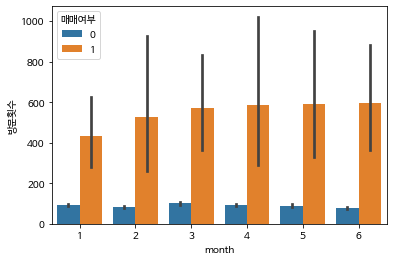

In [ ]:
sns.barplot(data = GA_buy_sell_result, x = 'month', y = '방문일자_s', hue = '매매여부')
plt.ylabel('방문횟수')
plt.show()

고객의 주식거래여부가 중요한 이유는 앱 방문횟수에서도 알 수 있다. 주식 매매를 하는 고객의 방문횟수는 그렇지 않은 고객의 방문횟수보다 훨씬 웃돌아, 주식거래를 하는 고객을 전략적으로 유치시켜야한다는 사실을 알아낼 수 있다.

### 2.4.3 이벤트범주 별 접속 횟수

현재 고객들의 앱 사용유형을 살펴보면 대부분의 고객들은 주식을 모니터링하고 매매하는 데에 앱을 사용한다는 것을 알 수 있다.

# 3. 분석 진행

## 3.1 투자간격에 따른 1차 고객 분류

### 3.1.1 투자간격에 대한 정의

기존에 제공된 '기본주식거래유형코드'의 정의를 바탕으로 매수/매도 사이의 간격이 짧고 긴 고객을 분류하였다.
* 단기 : Scalper(001), Day Trader(002), Swing Trader(003), General Trader(004), Recent Dormancy(008)
* 중장기 : Occasional Trader(005), Recent Dormancy(008), Dormancy(009)
* 장기 : Long-Term Trader(006), Stock Holder(010)  

> Recent Dormancy(008)의 경우 '전월 매매 & 당월 비매매 고객' 이라고 정의되어 있는데, 본래 장기의 투자 성향을 가지는 고객이 우연히 전월 매매를 이룬 경우가 있을 것이라고 생각되었다. 그렇기에 전월 매매 건수 30개를 기준으로 보다 많거나 같은 수의 거래가 이루어진 경우 단기 투자자로, 보다 적은 수의 거래가 이루어진 경우 중장기 투자자로 분류하였다.


In [ ]:
df_008 = cus_info[cus_info['기본주식거래유형코드']=='008'].reset_index(drop=True)

korea_df = kr_stk[(kr_stk['주문날짜'] > 20220500)&(kr_stk['주문날짜'] < 20220600)].reset_index(drop=True)
oversea_df = oss_stk[(oss_stk['주문날짜'] > 20220500)&(oss_stk['주문날짜'] < 20220600)].reset_index(drop=True)

korea_group = sqldf("select 계좌번호, count(주문날짜) as korea_count from korea_df group by 계좌번호")
oversea_group = sqldf("select 계좌번호, count(주문날짜) as oversea_count from oversea_df group by 계좌번호")

df_left= pd.merge(df_008, korea_group, left_on='계좌번호', right_on='계좌번호', how='left')
df_left= pd.merge(df_left, oversea_group, left_on='계좌번호', right_on='계좌번호', how='left').fillna(0)

df_left['5월주식거래'] = df_left['korea_count'] + df_left['oversea_count']

# 단기, 중장기 나누기 ----------------------------------------------------------------------------------------------------------
df_008_short = df_left[df_left['5월주식거래'] >= 30].reset_index(drop=True)
short_list = df_008_short['계좌번호'].tolist()
df_008_short.drop(['korea_count', 'oversea_count', '5월주식거래'], axis=1, inplace=True)

df_008_mid = df_left[df_left['5월주식거래'] < 30].reset_index(drop=True)
mid_list = df_008_mid['계좌번호'].tolist()
df_008_mid.drop(['korea_count', 'oversea_count', '5월주식거래'], axis=1, inplace=True)


# 각각 단기, 중장기에 해당하는 코드로 '기본주식거래유형코드'변경 ----------------------------------------------------------------
cus_info.loc[cus_info['계좌번호'].isin(short_list), '기본주식거래유형코드'] = '002'
cus_info.loc[cus_info['계좌번호'].isin(mid_list), '기본주식거래유형코드'] = '005'

cus_info['기본주식거래유형코드'].value_counts() # 008이 사라진 것을 확인 가능

005    30488
010    17540
004     3045
003     2550
002     2340
_       1023
001      617
009      517
007      379
006      349
011      227
Name: 기본주식거래유형코드, dtype: int64

In [ ]:
# 분류된 투자간격에 따른 EDA를 진행하기 위해 '기간유형'이라는 열 생성
short = ['001', '002', '003', '004']
mid = ['005', '009']
long = ['006', '010']

cus_info['기간유형'] = 0 

for i in range(len(cus_info)):
  if cus_info['기본주식거래유형코드'][i] in short:
    cus_info['기간유형'][i] = '단기'
  elif cus_info['기본주식거래유형코드'][i] in mid:
    cus_info['기간유형'][i] = '중장기'
  elif cus_info['기본주식거래유형코드'][i] in long:
    cus_info['기간유형'][i] = '장기'
  else: cus_info['기간유형'][i] = np.nan
  
cus_info = cus_info.dropna().reset_index(drop=True)

### 3.1.2 투자간격별 EDA

한 줄 당 하나의 feature에 대한 plot을 나타낸다.  
살펴보면 투자 간격 유형 별로 주거래업종구분코드나 고객등급코드 등의 분포가 확연하게 다른 것을 확인할 수 있고,  
**이는 곧 분석에서 분류한 투자간격은 고객의 주식성향을 나타낼 수 있는 지표로 활용 가능함을 뜻한다.**

### 파일 저장

In [ ]:
# cus_info.to_csv("./temp_data/cus_info.csv")
# kr_stk.to_csv("./temp_data/kr_stk.csv")
# oss_stk.to_csv("./temp_data/oss_stk.csv")
# bnc_data.to_csv("./temp_data/bnc_data.csv")
# aet_data.to_csv("./temp_data/aet_data.csv")

## 3.2 파생변수 생성

특정 주식 거래가 주가 지수의 흐름을 잘 예측하고 성사된 것인지 파악하기 위한 변수로써 '주가지수 반영 정도' 변수를 생성했다. 제공된 국내/해외주식 거래 데이터와 더불어 코스닥, 코스피, 나스닥 종합 지수 데이터와 이에 속한 기업 리스트를 외부 데이터로 사용했다.  
변수 생성 과정은 아래와 같다.  

> Step 1. 코스피, 코스닥, 나스닥 종합 지수 데이터에 (5일 후의 지수 - 해당일자의 지수) 를 적용한 style 칼럼을 생성  
Step 2. 국내주식거래데이터의 경우, 종목코드를 코스피/코스닥 기업 리스트와 대조하여 각 지수에 맞는 style을 입력. 해외주식거래데이터는 나스닥 종합지수 style을 일괄 적용  
Step 3. 만약 사용자가 매도를 한 경우, style의 부호를 변환   
Step 4. 계좌번호로 그룹핑을 한 후, style 평균을 칼럼으로 생성  
Step 5. 계좌번호에 있는 국내 style과 해외 style에 MinMaz 스케일링을 적용한 후, 둘을 평균내어 최종 style 변수 생성  
Step 6. style 지수가 없는 경우, 주식 거래를 하지 않는 고객이므로 삭제

사용한 코스피, 코스닥 지수의 데이터는 외부데이터로 investing.com에서 과거데이터 조회 후 불러온 것이다.  
나스닥 지수의 데이터는 파이썬에서 제공하는 패키지를 사용하였다.

In [ ]:
data_ks = pd.read_csv('./data/코스피지수 내역.csv')

data_ks.reset_index(inplace=True)
data_ks['날짜'] = data_ks['날짜'].astype('str')
for n in range(len(data_ks)):
    li = data_ks['날짜'][n].split('-')
    data_ks['날짜'][n] = "".join(li)
    
data_ks = data_ks[['날짜', '종가']]
for i in range(len(data_ks)):
    data_ks['날짜'][i] = data_ks['날짜'][i].replace(' ', '')
    data_ks['종가'][i] = data_ks['종가'][i].replace(',', '')

data_ks = data_ks.astype({'날짜': 'int64', '종가': 'float'})


data_kq = pd.read_csv('./data/코스닥 내역.csv')

data_kq.reset_index(inplace=True)
data_kq['날짜'] = data_kq['날짜'].astype('str')
for n in range(len(data_ks)):
    li = data_kq['날짜'][n].split('-')
    data_kq['날짜'][n] = "".join(li)
    
data_kq = data_kq[['날짜', '종가']]
for i in range(len(data_kq)):
    data_kq['날짜'][i] = data_kq['날짜'][i].replace(' ', '')
    data_kq['종가'][i] = data_kq['종가'][i].replace(',', '')
    
data_kq = data_kq.astype({'날짜': 'int64', '종가': 'float'})



data_ks['5_Close'] = data_ks['종가'].shift(5)
data_ks['15_Close'] = data_ks['종가'].shift(15)
data_ks['30_Close'] = data_ks['종가'].shift(30)
data_kq['5_Close'] = data_kq['종가'].shift(5)
data_kq['15_Close'] = data_kq['종가'].shift(15)
data_kq['30_Close'] = data_kq['종가'].shift(30)

data_ks['style_5'] = data_ks['5_Close'] - data_ks['종가']
data_ks['style_15'] = data_ks['15_Close'] - data_ks['종가']
data_ks['style_30'] = data_ks['30_Close'] - data_ks['종가']
data_kq['style_5'] = data_kq['5_Close'] - data_kq['종가']
data_kq['style_15'] = data_kq['15_Close'] - data_kq['종가']
data_kq['style_30'] = data_kq['30_Close'] - data_kq['종가']

In [ ]:
df_ix = fdr.DataReader('IXIC','2021')
df_ix.reset_index(inplace=True)
df_ix['Date'] = df_ix['Date'].astype('str')
for n in range(len(df_ix)):
    li = df_ix['Date'][n].split('-')
    df_ix['Date'][n] = "".join(li)
    
df_ix= df_ix[['Date', 'Close']]
df_ix = df_ix.astype({'Date': 'int64'})

df_ix['5_Close'] = df_ix['Close'].shift(-5)
  # 15 거래일 후의 지수 뽑고, 합치기
df_ix['15_Close'] = df_ix['Close'].shift(-15)
  # 30 거래일 후의 지수 뽑고, 합치기
df_ix['30_Close'] = df_ix['Close'].shift(-30)
  # 5/15/30 style 칼럼 생성
df_ix['style_5'] = df_ix['5_Close'] - df_ix['Close']
df_ix['style_15'] = df_ix['15_Close'] - df_ix['Close']
df_ix['style_30'] = df_ix['30_Close'] - df_ix['Close']
display(df_ix.head())

,Date,Close,5_Close,15_Close,30_Close,style_5,style_15,style_30
0,20210104,12698.450195,13036.429688,13626.059570,13965.490234,337.979493,927.609375,1267.040039
1,20210105,12818.959961,13072.429688,13270.599609,13865.360352,253.469727,451.639648,1046.400391
2,20210106,12740.790039,13128.950195,13337.160156,13874.459961,388.160156,596.370117,1133.669922
3,20210107,13067.480469,13112.639648,13070.690430,13533.049805,45.159179,3.209961,465.569336
4,20210108,13201.980469,12998.500000,13403.389648,13465.200195,-203.480469,201.409179,263.219726


In [ ]:
# Step 2. 코스피, 코스닥 종목 코드 데이터를 불러오고, 기존 거래 데이터와 종목코드를 대조하여 알맞은 style 값을 입력
# * 해외주식거래는 나스닥 종합지수를 일괄 적용
df_krx = fdr.StockListing('KRX')
df_ks_list = df_krx[df_krx['Market'] == 'KOSPI'].copy()
df_ks_list.reset_index(drop=True, inplace=True)
df_kq_list = df_krx[df_krx['Market'] == 'KOSDAQ'].copy()
df_kq_list.reset_index(drop=True, inplace=True)
# 각 시장별 종목 코드 데이터
kospi_list = df_ks_list['Code'].tolist()
kosdaq_list = df_kq_list['Code'].tolist()

# Step 2.2. 대조하여 알맞은 style 값 넣기
style_list_5 = []
style_list_15 = []
style_list_30 = []
kdaq = 0
kopi = 0
for i in tqdm(range(len(kr_stk))):
  n = kr_stk['종목코드'][i][1:]
  n = n.replace(" ", "")
  time = kr_stk['주문날짜'][i]
  m = kr_stk['매매구분코드'][i]
  if n in kosdaq_list:
    try:
      df_li = data_kq[data_kq['날짜'] == time].iloc[-1]
    except :
      print(time)
      display(data_kq[data_kq['날짜'] == time])
    s_5 = df_li['style_5']
    s_15 = df_li['style_15']
    s_30 = df_li['style_30']
    kdaq += 1
  else:
    df_li = data_ks[data_ks['날짜'] == time].iloc[-1]
    s_5 = df_li['style_5']
    s_15 = df_li['style_15']
    s_30 = df_li['style_30']
    kopi += 1
  # Step 3. 사용자가 매도를 한 경우, style 부호를 변환
  if m == 1:
    s_5 = -s_5
    s_15 = -s_15
    s_30 = -s_30
  style_list_5.append(s_5)
  style_list_15.append(s_15)
  style_list_30.append(s_30)


kr_stk['style_5'] = style_list_5
kr_stk['style_15'] = style_list_15
kr_stk['style_30'] = style_list_30
print(f'코스닥 분류 : {kdaq}')
print(f'코스피 분류 : {kopi}')
display(kr_stk.head())

# Step 2.3. 해외주식 style 일괄 적용
style_list_5 = []
style_list_15 = []
style_list_30 = []
for i in tqdm(range(len(oss_stk))):
  time = oss_stk['주문날짜'][i]
  try:
    df_li = df_ix[df_ix['Date'] <= time].iloc[-1]
    s_5 = df_li['style_5']
    s_15 = df_li['style_15']
    s_30 = df_li['style_30']
  except:
    s = 0

  m = oss_stk['매매구분코드'][i]
  # Step 3. 사용자가 매도를 한 경우, style 부호를 변환
  if m == 1:
    s_5 = -s_5
    s_15 = -s_15
    s_30 = -s_30
  style_list_5.append(s_5)
  style_list_15.append(s_15)
  style_list_30.append(s_30)


oss_stk['style_5'] = style_list_5
oss_stk['style_15'] = style_list_15
oss_stk['style_30'] = style_list_30
display(oss_stk.head())

100%|██████████| 503586/503586 [03:53<00:00, 2154.83it/s]


코스닥 분류 : 250878
코스피 분류 : 252708


,계좌번호,주문날짜,주문순서,주문접수시간대,최종체결시간대,종목코드,매매구분코드,체결건수,체결외화단가,주문매체구분코드,style_5,style_15,style_30
0,baee84002daf5d4428067edb7507c83d1411a1bbe013af...,20220427,1,14,14,A006800,2,85.0,7890.0,3,38.51,-46.72,-134.55
1,baee84002daf5d4428067edb7507c83d1411a1bbe013af...,20220304,1,12,12,A271940,2,10.0,39600.0,3,-67.78,16.13,-20.22
2,baee84002daf5d4428067edb7507c83d1411a1bbe013af...,20220207,1,10,10,A100790,1,100.0,9100.0,3,46.61,18.33,-31.17
3,4d95fb22c2608cd427867182a75c5db9ddfafe3476d56c...,20220511,2,10,10,A160980,2,1.0,17200.0,3,5.23,24.80,-116.04
4,4d95fb22c2608cd427867182a75c5db9ddfafe3476d56c...,20220511,1,10,10,A160980,2,1.0,17250.0,3,5.23,24.80,-116.04


100%|██████████| 51902/51902 [00:21<00:00, 2375.51it/s]


,계좌번호,주문날짜,주문순서,주문접수시간대,최종체결시간대,종목코드,매매구분코드,체결건수,체결외화단가,주문매체구분코드,거래통화코드,거래통화환율,style_5,style_15,style_30
0,89ec90b53373d769cd2e9554330d3966d6c9aa6d8db503...,20220401,2,1,1,US5494981039,2,9.0,24.5100,3,USD,1210.7,-550.500000,-1256.650391,-2598.709961
1,89ec90b53373d769cd2e9554330d3966d6c9aa6d8db503...,20220401,1,1,1,US5494981039,2,2.0,24.4600,3,USD,1210.7,-550.500000,-1256.650391,-2598.709961
2,89ec90b53373d769cd2e9554330d3966d6c9aa6d8db503...,20220503,1,22,22,US5494981039,1,11.0,19.0600,3,USD,1265.8,826.089844,1299.309571,1464.609375
3,89ec90b53373d769cd2e9554330d3966d6c9aa6d8db503...,20220324,1,22,22,US5494981039,1,1.0,26.0312,3,USD,1212.7,-28.679687,840.759766,2047.179688
4,89ec90b53373d769cd2e9554330d3966d6c9aa6d8db503...,20220303,1,23,23,US5494981039,2,1.0,24.2100,3,USD,1205.0,-407.980469,653.899414,-186.860352


In [ ]:
# Step 4. 계좌번호로 그룹핑을 한 후, style 평균을 칼럼으로 생성
# 국내/해외 style 그룹핑
kor_cus = sqldf("select 계좌번호, sum(style_5) as 한국주식스타일합계_5, sum(style_5)/count(style_5) as 한국주식스타일평균_5, sum(style_15) as 한국주식스타일합계_15, sum(style_15)/count(style_5) as 한국주식스타일평균_15, sum(style_30) as 한국주식스타일합계_30, sum(style_30)/count(style_5) as 한국주식스타일평균_30, count(style_5) as 한국주식거래수 from kr_stk group by 계좌번호")
oss_cus = sqldf("select 계좌번호, sum(style_5) as 해외주식스타일합계_5, sum(style_5)/count(style_5) as 해외주식스타일평균_5, sum(style_15) as 해외주식스타일합계_15, sum(style_15)/count(style_5) as 해외주식스타일평균_15, sum(style_30) as 해외주식스타일합계_30, sum(style_30)/count(style_5) as 해외주식스타일평균_30, count(style_5) as 해외주식거래수 from oss_stk group by 계좌번호")

df = pd.merge(kor_cus, oss_cus, how = 'outer', on = '계좌번호').replace(np.nan, 0)
df

,계좌번호,한국주식스타일합계_5,한국주식스타일평균_5,한국주식스타일합계_15,한국주식스타일평균_15,한국주식스타일합계_30,한국주식스타일평균_30,한국주식거래수,해외주식스타일합계_5,해외주식스타일평균_5,해외주식스타일합계_15,해외주식스타일평균_15,해외주식스타일합계_30,해외주식스타일평균_30,해외주식거래수
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,73.84,36.920000,62.10,31.050000,-26.73,-13.365000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03...,-607.04,-0.886190,-975.02,-1.423387,-1602.26,-2.339066,685.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,003b998c70775d3f079d89ed932345ef3276d2a35d93a5...,25.68,0.546383,-679.93,-14.466596,-2237.31,-47.602340,47.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0041e009e19878cd52dca944d43ab4a0492ea981425bc6...,-403.14,-21.217895,-851.40,-44.810526,-1431.86,-75.361053,19.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,006112ef04dbdc2a5e19a85e0d9a5e8b31a4ecf37b4244...,-86.06,-21.515000,-463.37,-115.842500,-1101.78,-275.445000,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6962,fa60f54d2cf1e0a4f218c6e1d81abf803d8edec4abc01b...,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.0,272.749024,136.374512,-664.930664,-332.465332,-1461.201172,-730.600586,2.0
6963,fabe40fad0f431443dda0902d0d75efe7b2fe9953b83ef...,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.0,-511.790039,-170.596680,-1206.419922,-402.139974,-1219.950195,-406.650065,3.0
6964,fb659457c01ef6e3f8ba02bdd747e67bbd7e472ada21d6...,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.0,387.098633,129.032878,569.079101,189.693034,1154.838867,384.946289,3.0
6965,fdda44eaab683c0fb076c9d5ecb7df05d43303cd16fd7c...,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.0,-1119.217776,-39.972063,9458.756838,337.812744,734.707030,26.239537,28.0


#### 한국스타일 스케일링



*   0이 아닌 한국주식스타일평균만을 뽑아냈다.
*   남은 한국스타일변수에 대해 Minmax Scaling을 진행했다.



In [ ]:
# 5일 style ------------------------------------------------------------------------------------------------
kr_style = df[df['한국주식스타일평균_5'] != 0][['계좌번호', '한국주식스타일평균_5']].reset_index()
kr_style['한국주식스타일 스케일_5'] = kr_style['한국주식스타일평균_5'].copy()

minmax = MinMaxScaler(feature_range = (0, 1))
kr_style['한국주식스타일 스케일_5'] = pd.DataFrame(minmax.fit_transform(kr_style[['한국주식스타일평균_5']]))

kr_style_5 = kr_style[['계좌번호', '한국주식스타일 스케일_5']]


# 15일 style ------------------------------------------------------------------------------------------------
kr_style = df[df['한국주식스타일평균_15'] != 0][['계좌번호', '한국주식스타일평균_15']].reset_index()
kr_style['한국주식스타일 스케일_15'] = kr_style['한국주식스타일평균_15'].copy()

minmax = MinMaxScaler(feature_range = (0, 1))
kr_style['한국주식스타일 스케일_15'] = pd.DataFrame(minmax.fit_transform(kr_style[['한국주식스타일평균_15']]))

kr_style_15 = kr_style[['계좌번호', '한국주식스타일 스케일_15']]


# 30일 style ------------------------------------------------------------------------------------------------
kr_style = df[df['한국주식스타일평균_30'] != 0][['계좌번호', '한국주식스타일평균_30']].reset_index()
kr_style['한국주식스타일 스케일_30'] = kr_style['한국주식스타일평균_30'].copy()

minmax = MinMaxScaler(feature_range = (0, 1))
kr_style['한국주식스타일 스케일_30'] = pd.DataFrame(minmax.fit_transform(kr_style[['한국주식스타일평균_30']]))

kr_style_30 = kr_style[['계좌번호', '한국주식스타일 스케일_30']]

#### 해외스타일 스케일링

In [ ]:
# 5일 style ------------------------------------------------------------------------------------------------
oss_style = df[df['해외주식스타일평균_5'] != 0][['계좌번호', '해외주식스타일평균_5']].reset_index()
oss_style['해외주식스타일 스케일_5'] = oss_style['해외주식스타일평균_5'].copy()

minmax = MinMaxScaler(feature_range = (0, 1))
oss_style['해외주식스타일 스케일_5'] = pd.DataFrame(minmax.fit_transform(oss_style[['해외주식스타일평균_5']]))

oss_style_5 = oss_style[['계좌번호', '해외주식스타일 스케일_5']]


# 15일 style ------------------------------------------------------------------------------------------------
oss_style = df[df['해외주식스타일평균_15'] != 0][['계좌번호', '해외주식스타일평균_15']].reset_index()
oss_style['해외주식스타일 스케일_15'] = oss_style['해외주식스타일평균_15'].copy()

minmax = MinMaxScaler(feature_range = (0, 1))
oss_style['해외주식스타일 스케일_15'] = pd.DataFrame(minmax.fit_transform(oss_style[['해외주식스타일평균_15']]))

oss_style_15 = oss_style[['계좌번호', '해외주식스타일 스케일_15']]


# 30일 style ------------------------------------------------------------------------------------------------
oss_style = df[df['해외주식스타일평균_30'] != 0][['계좌번호', '해외주식스타일평균_30']].reset_index()
oss_style['해외주식스타일 스케일_30'] = oss_style['해외주식스타일평균_30'].copy()

minmax = MinMaxScaler(feature_range = (0, 1))
oss_style['해외주식스타일 스케일_30'] = pd.DataFrame(minmax.fit_transform(oss_style[['해외주식스타일평균_30']]))

oss_style_30 = oss_style[['계좌번호', '해외주식스타일 스케일_30']]

*   두 스케일한 지수를 합쳤다.(outer 형태로 합치고 NaN은 0으로 처리)
*   둘 중 0이 있는 경우, 0이 아닌 스타일변수를 사용했다.
*   한국/해외 모두 0이 아닌 경우, 두 스타일변수의 평균을 내어 사용했다.

In [ ]:
# 5일 style ------------------------------------------------------------------------------------------------
df_scale_5 = pd.merge(kr_style_5, oss_style_5, on = '계좌번호', how = 'outer')
df_scale_5 = df_scale_5.fillna(0)
df_scale_5[(df_scale_5['한국주식스타일 스케일_5'] == 0)&(df_scale_5['해외주식스타일 스케일_5'] == 0)]

# 15일 style ------------------------------------------------------------------------------------------------
df_scale_15 = pd.merge(kr_style_15, oss_style_15, on = '계좌번호', how = 'outer')
df_scale_15 = df_scale_15.fillna(0)
df_scale_15[(df_scale_15['한국주식스타일 스케일_15'] == 0)&(df_scale_15['해외주식스타일 스케일_15'] == 0)]

# 30일 style ------------------------------------------------------------------------------------------------
df_scale_30 = pd.merge(kr_style_30, oss_style_30, on = '계좌번호', how = 'outer')
df_scale_30 = df_scale_30.fillna(0)
df_scale_30[(df_scale_30['한국주식스타일 스케일_30'] == 0)&(df_scale_30['해외주식스타일 스케일_30'] == 0)]

,계좌번호,한국주식스타일 스케일_30,해외주식스타일 스케일_30
1839,4783bf6f6f4bac7726fd721f362c413cc41ab8e0492e3e...,0.0,0.0


In [ ]:
# 5일 style ------------------------------------------------------------------------------------------------
df_scale_5['스타일스케일_5'] = df_scale_5['한국주식스타일 스케일_5'].copy()

for i in range(len(df_scale_5)):
  if (df_scale_5['한국주식스타일 스케일_5'][i] != 0) & (df_scale_5['해외주식스타일 스케일_5'][i] == 0):
    df_scale_5['스타일스케일_5'][i] = df_scale_5['한국주식스타일 스케일_5'][i]
  elif (df_scale_5['한국주식스타일 스케일_5'][i] == 0) & (df_scale_5['해외주식스타일 스케일_5'][i] != 0):
    df_scale_5['스타일스케일_5'][i] = df_scale_5['해외주식스타일 스케일_5'][i]
  elif (df_scale_5['한국주식스타일 스케일_5'][i] != 0) & (df_scale_5['해외주식스타일 스케일_5'][i] != 0):
    df_scale_5['스타일스케일_5'][i] = (df_scale_5['한국주식스타일 스케일_5'][i] + df_scale_5['해외주식스타일 스케일_5'][i]) / 2
  else: 
    df_scale_5['스타일스케일_5'][i] = 0
  

# 15일 style ------------------------------------------------------------------------------------------------
df_scale_15['스타일스케일_15'] = df_scale_15['한국주식스타일 스케일_15'].copy()

for i in range(len(df_scale_15)):
  if (df_scale_15['한국주식스타일 스케일_15'][i] != 0) & (df_scale_15['해외주식스타일 스케일_15'][i] == 0):
    df_scale_15['스타일스케일_15'][i] = df_scale_15['한국주식스타일 스케일_15'][i]
  elif (df_scale_15['한국주식스타일 스케일_15'][i] == 0) & (df_scale_15['해외주식스타일 스케일_15'][i] != 0):
    df_scale_15['스타일스케일_15'][i] = df_scale_15['해외주식스타일 스케일_15'][i]
  elif (df_scale_15['한국주식스타일 스케일_15'][i] != 0) & (df_scale_15['해외주식스타일 스케일_15'][i] != 0):
    df_scale_15['스타일스케일_15'][i] = (df_scale_15['한국주식스타일 스케일_15'][i] + df_scale_15['해외주식스타일 스케일_15'][i]) / 2
  else: 
    df_scale_15['스타일스케일_15'][i] = 0


# 30일 style ------------------------------------------------------------------------------------------------
df_scale_30['스타일스케일_30'] = df_scale_30['한국주식스타일 스케일_30'].copy()

for i in range(len(df_scale_30)):
  if (df_scale_30['한국주식스타일 스케일_30'][i] != 0) & (df_scale_30['해외주식스타일 스케일_30'][i] == 0):
    df_scale_30['스타일스케일_30'][i] = df_scale_30['한국주식스타일 스케일_30'][i]
  elif (df_scale_30['한국주식스타일 스케일_30'][i] == 0) & (df_scale_30['해외주식스타일 스케일_30'][i] != 0):
    df_scale_30['스타일스케일_30'][i] = df_scale_30['해외주식스타일 스케일_30'][i]
  elif (df_scale_30['한국주식스타일 스케일_30'][i] != 0) & (df_scale_30['해외주식스타일 스케일_30'][i] != 0):
    df_scale_30['스타일스케일_30'][i] = (df_scale_30['한국주식스타일 스케일_30'][i] + df_scale_30['해외주식스타일 스케일_30'][i]) / 2
  else: 
    df_scale_30['스타일스케일_30'][i] = 0

In [ ]:
df = pd.merge(df, df_scale_5[['계좌번호', '스타일스케일_5']], on="계좌번호")
df = pd.merge(df, df_scale_15, how="inner", on="계좌번호")
df = pd.merge(df, df_scale_30, how="inner", on="계좌번호")

In [ ]:
df['주가지수반영정도_5'] = df ['스타일스케일_5']
df['주가지수반영정도_15'] = df ['스타일스케일_15']
df['주가지수반영정도_30'] = df ['스타일스케일_30']
df

,계좌번호,한국주식스타일합계_5,한국주식스타일평균_5,한국주식스타일합계_15,한국주식스타일평균_15,한국주식스타일합계_30,한국주식스타일평균_30,한국주식거래수,해외주식스타일합계_5,해외주식스타일평균_5,...,스타일스케일_5,한국주식스타일 스케일_15,해외주식스타일 스케일_15,스타일스케일_15,한국주식스타일 스케일_30,해외주식스타일 스케일_30,스타일스케일_30,주가지수반영정도_5,주가지수반영정도_15,주가지수반영정도_30
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,73.84,36.920000,62.10,31.050000,-26.73,-13.365000,2.0,0.000000,0.000000,...,0.574379,0.541781,0.000000,0.541781,0.481620,0.000000,0.481620,0.574379,0.541781,0.481620
1,00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03...,-607.04,-0.886190,-975.02,-1.423387,-1602.26,-2.339066,685.0,0.000000,0.000000,...,0.498215,0.498085,0.000000,0.498085,0.496783,0.000000,0.496783,0.498215,0.498085,0.496783
2,003b998c70775d3f079d89ed932345ef3276d2a35d93a5...,25.68,0.546383,-679.93,-14.466596,-2237.31,-47.602340,47.0,0.000000,0.000000,...,0.501101,0.480534,0.000000,0.480534,0.434537,0.000000,0.434537,0.501101,0.480534,0.434537
3,0041e009e19878cd52dca944d43ab4a0492ea981425bc6...,-403.14,-21.217895,-851.40,-44.810526,-1431.86,-75.361053,19.0,0.000000,0.000000,...,0.457255,0.439703,0.000000,0.439703,0.396362,0.000000,0.396362,0.457255,0.439703,0.396362
4,006112ef04dbdc2a5e19a85e0d9a5e8b31a4ecf37b4244...,-86.06,-21.515000,-463.37,-115.842500,-1101.78,-275.445000,4.0,0.000000,0.000000,...,0.456656,0.344122,0.000000,0.344122,0.121204,0.000000,0.121204,0.456656,0.344122,0.121204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6806,fa60f54d2cf1e0a4f218c6e1d81abf803d8edec4abc01b...,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.0,272.749024,136.374512,...,0.608882,0.000000,0.427520,0.427520,0.000000,0.399070,0.399070,0.608882,0.427520,0.399070
6807,fabe40fad0f431443dda0902d0d75efe7b2fe9953b83ef...,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.0,-511.790039,-170.596680,...,0.501277,0.000000,0.412331,0.412331,0.000000,0.450273,0.450273,0.501277,0.412331,0.450273
6808,fb659457c01ef6e3f8ba02bdd747e67bbd7e472ada21d6...,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.0,387.098633,129.032878,...,0.606309,0.000000,0.541354,0.541354,0.000000,0.575393,0.575393,0.606309,0.541354,0.575393
6809,fdda44eaab683c0fb076c9d5ecb7df05d43303cd16fd7c...,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.0,-1119.217776,-39.972063,...,0.547066,0.000000,0.573645,0.573645,0.000000,0.518696,0.518696,0.547066,0.573645,0.518696


In [ ]:
df_c = cus_info[cus_info['고객정보기준년월'] == 202206].copy()
df_c = pd.merge(df_c, df, how="inner", on="계좌번호").replace(np.nan, 0)
df_c

,고객번호,계좌번호,고객정보기준년월,MTS월단위접속패턴,성별,연령대,고객자산구간코드,수익금액구간코드,최초계좌개설일,주식상품보유여부,...,스타일스케일_5,한국주식스타일 스케일_15,해외주식스타일 스케일_15,스타일스케일_15,한국주식스타일 스케일_30,해외주식스타일 스케일_30,스타일스케일_30,주가지수반영정도_5,주가지수반영정도_15,주가지수반영정도_30
0,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202206,111111,1,4,1,1,20050309,Y,...,0.541037,0.601261,0.0,0.601261,0.600615,0.0,0.600615,0.541037,0.601261,0.600615
1,3072d776c716010235dd75b3195d760bf3c46e00deee4e...,afa2e6df88371acd0768c15a14aebf9e81ed131af729e3...,202206,111111,1,7,1,1,20091013,Y,...,0.621802,1.000000,0.0,1.000000,1.000000,0.0,1.000000,0.621802,1.000000,1.000000
2,dc6eb520d8a2ca7fcc5e95aef37120b8b1d91a3d30bd7e...,726a3295019efd88142038b123013623e26a217d2b08df...,202206,110000,1,5,1,1,20110914,Y,...,0.515465,0.501686,0.0,0.501686,0.492225,0.0,0.492225,0.515465,0.501686,0.492225
3,d11e0b4608537bc4cf260a2af2d5e04f0a1c58219c5008...,4f2a78f9a162f9c82350f40627ce1062afaefeb4ff34e7...,202206,1111,1,6,5,1,20150915,Y,...,0.498167,0.515071,0.0,0.515071,0.334232,0.0,0.334232,0.498167,0.515071,0.334232
4,a93943ad4a16323cd7ffb6efb3f52fe566139304ec6bde...,8010d50edbbcd1974e12cb20fbca3a3abea0088df3070e...,202206,111100,2,4,1,1,20151005,Y,...,0.551271,0.540220,0.0,0.540220,0.470020,0.0,0.470020,0.551271,0.540220,0.470020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6801,5d72c07ef7e854eaae4fbd7d43930d8837dce27af222a3...,14c189daaab2a720047ead876a13f0f983cb753183aca1...,202206,111111,2,6,1,1,20191223,N,...,0.520063,0.521419,0.0,0.521419,0.515763,0.0,0.515763,0.520063,0.521419,0.515763
6802,e12354d50ebde37bb3767b12141808c868f5c509a4a324...,e93cdb1c2d75d9f6f7e9803cacbd0144f6840b6346cb02...,202206,1100,1,2,1,1,20200907,Y,...,0.624481,0.539615,0.0,0.539615,0.710971,0.0,0.710971,0.624481,0.539615,0.710971
6803,da950d8faa29d096ed843b784a46a62a95afa63157cb89...,8ed5de3de69b7cbdfa22a69b546b856cb0a5b5f15d37d8...,202206,111111,2,3,1,1,20201221,Y,...,0.500751,0.478244,0.0,0.478244,0.464493,0.0,0.464493,0.500751,0.478244,0.464493
6804,94f7caefe90ce173f26d077084b7a337bb0d84c198a91e...,e6d3e46bc3a679c2ac46811862787bbfda4fa59acc013d...,202206,111111,2,3,1,1,20210616,Y,...,0.462937,0.461111,0.0,0.461111,0.456448,0.0,0.456448,0.462937,0.461111,0.456448


### 3.2.2 자산 대비 수익률

주식 투자에 대한 숙련도를 파악하기 위한 변수로서 '자산 대비 수익률' 변수를 생성했다. 사용된 데이터는 제공된 국내/해외주식 거래 데이터와 고객잔고정보 데이터이다.   
'수익'의 경우 매수와 매도가 주어진 기간 내에 모두 이루어져야 정확한 계산이 가능하게 된다. 하지만 만약 매수는 기간 내에 이루어지지 않았지만 매도는 이루어진 경우 또한 수익이 발생한 상황이므로, 데이터의 출발선인 1월 잔고 데이터 기준으로 해당 주식 내역이 존재하면 고객의 보유액을 이용하여 '수익'변수를 생성하였다.  
더 자세한 변수 생성 과정은 아래와 같다.


> Step 1. 각 고객의 보유주식 별 매도수량, 매도액 총합, 매수수량, 매수액 총합, 보유수량, 보유액 수량 열을 생성  
Step 2. '수익' 변수 생성    
Step 3. 자산에 대한 수익 비율 계산을 위해 고객의 1~6월의 자산 중 최대값을 도출  
Step 4. '수익'을 '최대 자산'으로 나누며 최종적으로 '자산 대비 수익률' 변수 생성   

수익 변수
* 매수/매도 모두 존재:   
[(매도액 합)/(매도수량) x min(매도수량, 매수수량)] -  [(매수액 합)/(매수수량) x min(매도수량, 매수수량)]  
* 매도만 존재:   
 [(매도액 합)/(매도수량) x min(매도수량, 보유수량)] -  [(보유액 합)/(보유수량) x min(매도수량, 보유수량)]  






In [ ]:
#해외주식 하는 고객
os_real = sqldf('select 계좌번호, count(a.계좌번호) as "해외 주식 거래횟수" from df_c as a group by a.계좌번호')
os_df = df_c.loc[df_c['계좌번호'].isin(os_real['계좌번호'])].reset_index(drop=True)
#해외주식 투자 횟수, 평균 매입액 열 추가
cnt = pd.DataFrame(oss_stk.groupby('계좌번호')['주문날짜'].count())
os_df = pd.merge(os_df, cnt, on='계좌번호')

In [ ]:
oss_stk2 = oss_stk.copy()
oss_stk2['체결외화단가']=oss_stk2['체결외화단가']*oss_stk2['거래통화환율']
data = pd.concat([kr_stk,oss_stk])
data=data[['계좌번호','주문날짜','종목코드','매매구분코드','체결건수','체결외화단가']]

#매도 데이터와 매수 데이터 분리
data_sell = data.loc[data['매매구분코드']==1].drop(['매매구분코드'], axis='columns')
data_buy = data.loc[data['매매구분코드']==2].drop(['매매구분코드'], axis='columns')

#같은 주식종목에 대해 aggregate
data_sell['총체결가']=data_sell['체결건수']*data_sell['체결외화단가']
sell_agg = data_sell.groupby(['계좌번호','종목코드']).agg({'체결건수': np.sum, '총체결가': np.sum})

data_buy['총체결가']=data_buy['체결건수']*data_buy['체결외화단가']
buy_agg = data_buy.groupby(['계좌번호','종목코드']).agg({'체결건수': np.sum, '총체결가': np.sum})
buy_agg

체결건수  \
계좌번호                                               종목코드                   
00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03d... A000230       1963.0   
                                                   A000440       1300.0   
                                                   A001250        424.0   
                                                   A001470       2167.0   
                                                   A002680          7.0   
...                                                                 ...   
ffbdd447034531f4364227bcf3959a210e1011f97e0dd45... A139480         20.0   
                                                   A205470         18.0   
                                                   A210540        100.0   
                                                   A361390         90.0   
ffdb8a101b04d93c8b09ddce17a7be84d0179908f3f4cc0... A101730         83.0   

                                                                       총체결가  
계좌번호                                               종목코드                      
00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03d... A000230       46910600.0  
                                                   A000440       44292450.0  
                                                   A001250        1890810.0  
                                                   A001470        6917980.0  
                                                   A002680          22160.0  
...                                                                     ...  
ffbdd447034531f4364227bcf3959a210e1011f97e0dd45... A139480        2300000.0  
                                                   A205470         224400.0  
                                                   A210540        1480000.0  
                                                   A361390        2972500.0  
ffdb8a101b04d93c8b09ddce17a7be84d0179908f3f4cc0... A101730        3419400.0  

[62207 rows x 2 columns]

In [ ]:
#데이터 병합
#이 때, 수익은 매도 기록이 있는 고객에 한해 구할 수 있으므로 left join
merged = pd.merge(sell_agg, buy_agg, on=['계좌번호', '종목코드'], how='left')
only_sell = merged.loc[merged['체결건수_y'].isnull()].reset_index() #매수기록 없음

In [ ]:
#1월 잔고 데이터
bnc_data1 = bnc_data.loc[bnc_data['기준년월']==202201]
bnc_data1 = bnc_data1[['계좌번호', '종목코드', '결제기준통합잔고수량', '결제기준현재평가금액']]

#매수 기록 없는 사람 대상으로 merge
merged2 = pd.merge(only_sell, bnc_data1, on=['계좌번호', '종목코드'], how='left')
merged2 = merged2.fillna(0).drop(['체결건수_y', '총체결가_y'], axis=1)

merged2['최소체결건수']=0
for i in range(len(merged2)):
  minn=min(merged2['체결건수_x'][i], merged2['결제기준통합잔고수량'][i])
  merged2['최소체결건수'][i]=minn

In [ ]:
# 매도기록만 있는 사람들의 수익
merged2['수익']=0
for i in range(len(merged2)):
  pf=merged2['총체결가_x'][i]/merged2['체결건수_x'][i]*merged2['최소체결건수'][i] - merged2['결제기준현재평가금액'][i]/merged2['결제기준통합잔고수량'][i]*merged2['최소체결건수'][i]
  merged2['수익'][i]=pf
merged2

,계좌번호,종목코드,체결건수_x,총체결가_x,결제기준통합잔고수량,결제기준현재평가금액,최소체결건수,수익
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,A377330,1.0,23000.0,0.0,0.0,0,NaN
1,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,A382900,1.0,51200.0,0.0,0.0,0,NaN
2,00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03...,A013360,300.0,1386000.0,300.0,1356000.0,300,30000.0
3,003b998c70775d3f079d89ed932345ef3276d2a35d93a5...,A002380,2.0,778000.0,2.0,775000.0,2,3000.0
4,006a6e98b78a502e4865df4f128140d67f076f594402c4...,A205470,2.0,63500.0,2.0,56800.0,2,6700.0
...,...,...,...,...,...,...,...,...
10017,ffbdd447034531f4364227bcf3959a210e1011f97e0dd4...,A028050,80.0,2040000.0,80.0,1724000.0,80,316000.0
10018,ffc0e6b3eaf8b59f8c471e4d6d68063106dc5bd2414ca5...,A001570,50.0,264000.0,50.0,299000.0,50,-35000.0
10019,ffd96d859770d62800f6f654fce913c50f9cbf809efcc8...,A146320,1.0,25000.0,0.0,0.0,0,NaN
10020,ffdb8a101b04d93c8b09ddce17a7be84d0179908f3f4cc...,A112040,23.0,3387900.0,23.0,3468400.0,23,-80500.0


In [ ]:
# 매도, 매수 기록 모두 있는 사람들
buy_sell = merged.loc[merged['체결건수_y'].notnull()].reset_index()
buy_sell['최소체결건수']=0
for i in range(len(buy_sell)):
  minn=min(buy_sell['체결건수_x'][i], buy_sell['체결건수_y'][i])
  buy_sell['최소체결건수'][i]=minn

buy_sell['수익']=0
for i in range(len(buy_sell)):
  pf=buy_sell['총체결가_x'][i]/buy_sell['체결건수_x'][i]*buy_sell['최소체결건수'][i] - buy_sell['총체결가_y'][i]/buy_sell['체결건수_y'][i]*buy_sell['최소체결건수'][i]
  buy_sell['수익'][i]=pf
buy_sell

,계좌번호,종목코드,체결건수_x,총체결가_x,체결건수_y,총체결가_y,최소체결건수,수익
0,00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03...,A000230,1963.0,46986600.0,1963.0,46910600.0,1963,76000
1,00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03...,A000440,1300.0,43925150.0,1300.0,44292450.0,1300,-367300
2,00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03...,A001250,424.0,1837610.0,424.0,1890810.0,424,-53200
3,00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03...,A001470,2167.0,6804435.0,2167.0,6917980.0,2167,-113545
4,00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03...,A002680,7.0,21070.0,7.0,22160.0,7,-1090
...,...,...,...,...,...,...,...,...
45103,ffbdd447034531f4364227bcf3959a210e1011f97e0dd4...,A072770,22209.0,47421560.0,28698.0,60592000.0,22209,530218
45104,ffbdd447034531f4364227bcf3959a210e1011f97e0dd4...,A090710,476.0,440776.0,26.0,24870.0,26,-794
45105,ffbdd447034531f4364227bcf3959a210e1011f97e0dd4...,A205470,50.0,1270000.0,18.0,224400.0,18,232800
45106,ffbdd447034531f4364227bcf3959a210e1011f97e0dd4...,A210540,100.0,1505000.0,100.0,1480000.0,100,25000


In [ ]:
#최종 수익 집계
pf_all = pd.concat([merged2[['계좌번호','수익']], buy_sell[['계좌번호','수익']]])
pf_all = pf_all.groupby(['계좌번호']).sum('수익')
pf_all = pf_all.drop(pf_all[pf_all['수익']==0].index)
# result = pd.merge(df_c, pf_all, on = '계좌번호')

result = pd.merge(df_c, pf_all, how="inner", on="계좌번호")

In [ ]:
#자산대비수익 생성
aet = aet_data[['계좌번호','2022년1월총자산', '2022년2월총자산', '2022년3월총자산', '2022년4월총자산', '2022년5월총자산', '2022년6월총자산']]
aet = aet.fillna(0)
aet['최대자산']=0
for i in range(len(aet)):
  aet['최대자산'][i] = max(aet['2022년1월총자산'][i], aet['2022년2월총자산'][i], aet['2022년3월총자산'][i],
                       aet['2022년4월총자산'][i], aet['2022년5월총자산'][i], aet['2022년6월총자산'][i])
aet = aet[['계좌번호', '최대자산']]

result = pd.merge(result, aet, on = '계좌번호', how='left')
result['자산대비수익'] = result['수익']/result['최대자산']
result

,고객번호,계좌번호,고객정보기준년월,MTS월단위접속패턴,성별,연령대,고객자산구간코드,수익금액구간코드,최초계좌개설일,주식상품보유여부,...,스타일스케일_15,한국주식스타일 스케일_30,해외주식스타일 스케일_30,스타일스케일_30,주가지수반영정도_5,주가지수반영정도_15,주가지수반영정도_30,수익,최대자산,자산대비수익
0,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202206,111111,1,4,1,1,20050309,Y,...,0.601261,0.600615,0.000000,0.600615,0.541037,0.601261,0.600615,30820.0,2261986,0.013625
1,3072d776c716010235dd75b3195d760bf3c46e00deee4e...,afa2e6df88371acd0768c15a14aebf9e81ed131af729e3...,202206,111111,1,7,1,1,20091013,Y,...,1.000000,1.000000,0.000000,1.000000,0.621802,1.000000,1.000000,-2700.0,2891504,-0.000934
2,dc6eb520d8a2ca7fcc5e95aef37120b8b1d91a3d30bd7e...,726a3295019efd88142038b123013623e26a217d2b08df...,202206,110000,1,5,1,1,20110914,Y,...,0.501686,0.492225,0.000000,0.492225,0.515465,0.501686,0.492225,5.0,124311,0.000040
3,70b361ffdfc614a2e17b7ffa57f949f0a2ceb84f021ded...,7a7cb253b2f7172299c5c051c489ad90a6599190ef3683...,202206,111111,1,6,1,1,20171011,Y,...,0.467531,0.635954,0.000000,0.635954,0.439824,0.467531,0.635954,53100.0,358599,0.148076
4,771a23c5dd069e7a49dc3e4dc841f6af99ec6b3715cfee...,f2094bb718670ded9d4fc39b1f0a96c87bb6455f506b0b...,202206,111111,2,3,3,1,20180127,Y,...,0.466773,0.431190,0.000000,0.431190,0.462023,0.466773,0.431190,-217559.0,53883552,-0.004038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4659,63e58a49d8df82d4f4ae7a1672eab86b47c89e0e4ec53a...,310628f1c137e8b13ebb89d4cebe719dc1f7c2ce4cd3d7...,202206,111110,1,2,2,1,20201116,Y,...,0.492873,0.394118,0.468664,0.431391,0.523714,0.492873,0.431391,114500.0,13968445,0.008197
4660,5d72c07ef7e854eaae4fbd7d43930d8837dce27af222a3...,14c189daaab2a720047ead876a13f0f983cb753183aca1...,202206,111111,2,6,1,1,20191223,N,...,0.521419,0.515763,0.000000,0.515763,0.520063,0.521419,0.515763,-564755.0,35660165,-0.015837
4661,e12354d50ebde37bb3767b12141808c868f5c509a4a324...,e93cdb1c2d75d9f6f7e9803cacbd0144f6840b6346cb02...,202206,1100,1,2,1,1,20200907,Y,...,0.539615,0.710971,0.000000,0.710971,0.624481,0.539615,0.710971,2356620.0,7576775,0.311032
4662,da950d8faa29d096ed843b784a46a62a95afa63157cb89...,8ed5de3de69b7cbdfa22a69b546b856cb0a5b5f15d37d8...,202206,111111,2,3,1,1,20201221,Y,...,0.478244,0.464493,0.000000,0.464493,0.500751,0.478244,0.464493,323590.0,4985000,0.064913


### 3.2.3 체결건수

In [ ]:
kr_sum_qty = pd.DataFrame(kr_stk.groupby(by = '계좌번호').체결건수.sum()).reset_index()
oss_sum_qty = pd.DataFrame(oss_stk.groupby(by = '계좌번호').체결건수.sum()).reset_index()

sum_qty = pd.merge(kr_sum_qty, oss_sum_qty, on = '계좌번호')
sum_qty['체결건수'] = sum_qty['체결건수_x'] + sum_qty['체결건수_y']
sum_qty.columns = ['계좌번호', '국내주식체결건수', '해외주식체결건수', '체결건수']
sum_qty = sum_qty[['계좌번호', '체결건수']]
sum_qty

,계좌번호,체결건수
0,00d7b2324aa1636e64f96653280a103bfe2155ec7dcf2f...,20039.0
1,0144ac7b999a0b4bda86a69a542a9d47eb16792d9c8966...,78.0
2,01b5cea602f2495e716897e72ddac5856f909531c50a5a...,301.0
3,02a70f8ddd0d1613beb60bc8c2e671df0f994de6d1832e...,26.0
4,02f629144e91d0f6698e9cba35779d0d8a4f180b90c1b9...,27754.0
...,...,...
665,fdaa90e8ebfbff173a9675248c222e85a8ebc84c79ae12...,71.0
666,fe37598832877cce1ac57811788d85b9985207d30dcb50...,558.0
667,fec61e97b6076b294e89d19d52f81c7bc181e9c54e1b58...,99.0
668,fee446b55745eca0829b4773db0720983555f9d6e41866...,158.0


In [ ]:
result = pd.merge(result, sum_qty, on = '계좌번호', how = 'left')
result = result.fillna({'체결건수' : 0})
result

,고객번호,계좌번호,고객정보기준년월,MTS월단위접속패턴,성별,연령대,고객자산구간코드,수익금액구간코드,최초계좌개설일,주식상품보유여부,...,한국주식스타일 스케일_30,해외주식스타일 스케일_30,스타일스케일_30,주가지수반영정도_5,주가지수반영정도_15,주가지수반영정도_30,수익,최대자산,자산대비수익,체결건수
0,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202206,111111,1,4,1,1,20050309,Y,...,0.600615,0.000000,0.600615,0.541037,0.601261,0.600615,30820.0,2261986,0.013625,0.0
1,3072d776c716010235dd75b3195d760bf3c46e00deee4e...,afa2e6df88371acd0768c15a14aebf9e81ed131af729e3...,202206,111111,1,7,1,1,20091013,Y,...,1.000000,0.000000,1.000000,0.621802,1.000000,1.000000,-2700.0,2891504,-0.000934,0.0
2,dc6eb520d8a2ca7fcc5e95aef37120b8b1d91a3d30bd7e...,726a3295019efd88142038b123013623e26a217d2b08df...,202206,110000,1,5,1,1,20110914,Y,...,0.492225,0.000000,0.492225,0.515465,0.501686,0.492225,5.0,124311,0.000040,0.0
3,70b361ffdfc614a2e17b7ffa57f949f0a2ceb84f021ded...,7a7cb253b2f7172299c5c051c489ad90a6599190ef3683...,202206,111111,1,6,1,1,20171011,Y,...,0.635954,0.000000,0.635954,0.439824,0.467531,0.635954,53100.0,358599,0.148076,0.0
4,771a23c5dd069e7a49dc3e4dc841f6af99ec6b3715cfee...,f2094bb718670ded9d4fc39b1f0a96c87bb6455f506b0b...,202206,111111,2,3,3,1,20180127,Y,...,0.431190,0.000000,0.431190,0.462023,0.466773,0.431190,-217559.0,53883552,-0.004038,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4659,63e58a49d8df82d4f4ae7a1672eab86b47c89e0e4ec53a...,310628f1c137e8b13ebb89d4cebe719dc1f7c2ce4cd3d7...,202206,111110,1,2,2,1,20201116,Y,...,0.394118,0.468664,0.431391,0.523714,0.492873,0.431391,114500.0,13968445,0.008197,117.0
4660,5d72c07ef7e854eaae4fbd7d43930d8837dce27af222a3...,14c189daaab2a720047ead876a13f0f983cb753183aca1...,202206,111111,2,6,1,1,20191223,N,...,0.515763,0.000000,0.515763,0.520063,0.521419,0.515763,-564755.0,35660165,-0.015837,0.0
4661,e12354d50ebde37bb3767b12141808c868f5c509a4a324...,e93cdb1c2d75d9f6f7e9803cacbd0144f6840b6346cb02...,202206,1100,1,2,1,1,20200907,Y,...,0.710971,0.000000,0.710971,0.624481,0.539615,0.710971,2356620.0,7576775,0.311032,0.0
4662,da950d8faa29d096ed843b784a46a62a95afa63157cb89...,8ed5de3de69b7cbdfa22a69b546b856cb0a5b5f15d37d8...,202206,111111,2,3,1,1,20201221,Y,...,0.464493,0.000000,0.464493,0.500751,0.478244,0.464493,323590.0,4985000,0.064913,0.0


### 3.2.4 이상치 제거

<AxesSubplot:xlabel='자산대비수익', ylabel='주가지수반영정도_5'>

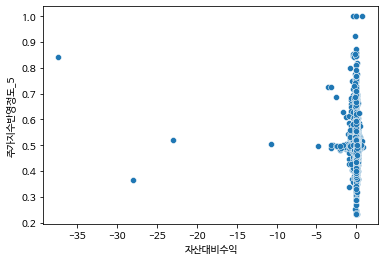

In [ ]:
sns.scatterplot(data=result, x="자산대비수익", y="주가지수반영정도_5")

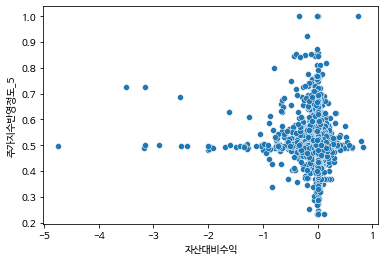

In [ ]:
sns.scatterplot(data=result[result['자산대비수익'] > -5], x="자산대비수익", y="주가지수반영정도_5")
result = result[result['자산대비수익'] > -5].copy()

### 3.2.5 환율, 미국국채금리, 변동성(vix), 통화량, 실업률 민감도

주식거래할 때의 각 데이터들의 변동량을 민감도로 활용하고자 한다. <br>
-> abs(주식주문날짜의 데이터 - 주문날짜 바로 이전의 데이터) = 변동량

In [ ]:
df_c = result.copy()

In [ ]:
# Step 1. 각 데이터의 DATE 칼럼 수정
def date_func(i):
  try:
    i.reset_index(inplace=True)
  except:
    pass
  try:
    i['DATE'] = i['DATE'].astype('str')
    i['Date'] = i['DATE']
  except:
    i['Date'] = i['Date'].astype('str')
  for n in range(len(i)):
    li = i['Date'][n].split('-')
    i['Date'][n] = "".join(li)
  return i

In [ ]:
#(1) 원달러 환율
df_exchange = fdr.DataReader('USD/KRW', start='2021')
df_exchange = date_func(df_exchange)
df_exchange = df_exchange[['Date', 'Close']]

#(2) 미국 국채 금리-20년, 10년, 5년, 1년
df_dgs = fdr.DataReader('FRED:DGS20,DGS10,DGS5,DGS1', start='2021')
df_dgs = date_func(df_dgs)
df_dgs['Close'] = df_dgs['DGS10']
df_dgs = df_dgs[['Date','Close']]

#(3) 변동성 지수(VIX)
df_vix = fdr.DataReader('VIX', start='2021')
df_vix = date_func(df_vix)
df_vix = df_vix[['Date', 'Close']]

#(4) 미국 M2 통화량
df_m2 = fdr.DataReader('FRED:M2SL', start='2021')
df_m2 = date_func(df_m2)
df_m2['Close'] = df_m2['M2SL']
df_m2 = df_m2[['Date', 'Close']]

#(5) 실업률(미국)
df_unrate = fdr.DataReader('FRED:UNRATE',  start='2021')
df_unrate = date_func(df_unrate)
df_unrate['Close'] = df_unrate['UNRATE']
df_unrate = df_unrate[['Date', 'Close']]

# Date 타입 변경
df_exchange = df_exchange.astype({'Date': 'int64'})
df_dgs = df_dgs.astype({'Date': 'int64'})
df_vix = df_vix.astype({'Date': 'int64'})
df_m2 = df_m2.astype({'Date': 'int64'})
df_unrate = df_unrate.astype({'Date': 'int64'})

In [ ]:
# Step 1.2. flun 칼럼 탄생시키기
for i in [df_exchange, df_dgs, df_vix, df_m2, df_unrate]:
  i['1'] = i['Close'].shift(1)
  i['flun'] = abs(i['Close'] - i['1'])
  display(i.head())

,Date,Close,1,flun
0,20210101,1084.650024,NaN,NaN
1,20210104,1084.729980,1084.650024,0.079956
2,20210105,1086.619995,1084.729980,1.890015
3,20210106,1086.449951,1086.619995,0.170044
4,20210107,1086.949951,1086.449951,0.500000


,Date,Close,1,flun
0,20210104,0.93,NaN,NaN
1,20210105,0.96,0.93,0.03
2,20210106,1.04,0.96,0.08
3,20210107,1.08,1.04,0.04
4,20210108,1.13,1.08,0.05


,Date,Close,1,flun
0,20210104,26.969999,NaN,NaN
1,20210105,25.340000,26.969999,1.629999
2,20210106,25.070000,25.340000,0.270000
3,20210107,22.370001,25.070000,2.699999
4,20210108,21.559999,22.370001,0.810002


,Date,Close,1,flun
0,20210101,19372.5,NaN,NaN
1,20210201,19615.2,19372.5,242.7
2,20210301,19853.8,19615.2,238.6
3,20210401,20110.7,19853.8,256.9
4,20210501,20418.7,20110.7,308.0


,Date,Close,1,flun
0,20210101,6.4,NaN,NaN
1,20210201,6.2,6.4,0.2
2,20210301,6.0,6.2,0.2
3,20210401,6.0,6.0,0.0
4,20210501,5.8,6.0,0.2


In [ ]:
# Step 2.2. 대조하여 알맞은 style 값 넣기
ex_flun = []
dgs_flun = []
vix_flun = []
m2_flun = []
unrate_flun = []
for i in tqdm(range(len(kr_stk))):
  time = kr_stk['주문날짜'][i]

  # 원달러 환율
  exchange = df_exchange[df_exchange['Date'] <= time].iloc[-1]
  exchange = exchange['flun']

  # 10년물 미국 국채 금리
  dgs = df_dgs[df_dgs['Date'] <= time].iloc[-1]
  dgs = dgs['flun']

  # vix 변동성
  vix = df_vix[df_vix['Date'] <= time].iloc[-1]
  vix = vix['flun']

  # m2 통화량
  m2 = df_m2[df_m2['Date'] <= time].iloc[-1]
  m2 = m2['flun']

  # unrate 미국 실업률
  unrate = df_unrate[df_unrate['Date'] <= time].iloc[-1]
  unrate = unrate['flun']

  ex_flun.append(exchange)
  dgs_flun.append(dgs)
  vix_flun.append(vix)
  m2_flun.append(m2)
  unrate_flun.append(unrate)

kr_stk['ex_flun'] = ex_flun
kr_stk['dgs_flun'] = dgs_flun
kr_stk['vix_flun'] = vix_flun
kr_stk['m2_flun'] = m2_flun
kr_stk['unrate_flun'] = unrate_flun

display(kr_stk.head())

100%|██████████| 503586/503586 [15:53<00:00, 528.29it/s]


,계좌번호,주문날짜,주문순서,주문접수시간대,최종체결시간대,종목코드,매매구분코드,체결건수,체결외화단가,주문매체구분코드,style_5,style_15,style_30,ex_flun,dgs_flun,vix_flun,m2_flun,unrate_flun
0,baee84002daf5d4428067edb7507c83d1411a1bbe013af...,20220427,1,14,14,A006800,2,85.0,7890.0,3,38.51,-46.72,-134.55,11.500000,0.05,1.920000,95.5,0.0
1,baee84002daf5d4428067edb7507c83d1411a1bbe013af...,20220304,1,12,12,A271940,2,10.0,39600.0,3,-67.78,16.13,-20.22,2.839966,0.12,1.500000,31.3,0.2
2,baee84002daf5d4428067edb7507c83d1411a1bbe013af...,20220207,1,10,10,A100790,1,100.0,9100.0,3,46.61,18.33,-31.17,3.239990,0.01,0.359998,58.8,0.2
3,4d95fb22c2608cd427867182a75c5db9ddfafe3476d56c...,20220511,2,10,10,A160980,2,1.0,17200.0,3,5.23,24.80,-116.04,1.690064,0.08,0.430001,5.0,0.0
4,4d95fb22c2608cd427867182a75c5db9ddfafe3476d56c...,20220511,1,10,10,A160980,2,1.0,17250.0,3,5.23,24.80,-116.04,1.690064,0.08,0.430001,5.0,0.0


In [ ]:
# Step 2.3. 해외주식 style 일괄 적용
ex_flun = []
dgs_flun = []
vix_flun = []
m2_flun = []
unrate_flun = []
for i in tqdm(range(len(oss_stk))):
  time = oss_stk['주문날짜'][i]

  # 원달러 환율
  exchange = df_exchange[df_exchange['Date'] <= time].iloc[-1]
  exchange = exchange['flun']

  # 10년물 미국 국채 금리
  dgs = df_dgs[df_dgs['Date'] <= time].iloc[-1]
  dgs = dgs['flun']

  # vix 변동성
  vix = df_vix[df_vix['Date'] <= time].iloc[-1]
  vix = vix['flun']

  # m2 통화량
  m2 = df_m2[df_m2['Date'] <= time].iloc[-1]
  m2 = m2['flun']

  # unrate 미국 실업률
  unrate = df_unrate[df_unrate['Date'] <= time].iloc[-1]
  unrate = unrate['flun']

  ex_flun.append(exchange)
  dgs_flun.append(dgs)
  vix_flun.append(vix)
  m2_flun.append(m2)
  unrate_flun.append(unrate)


oss_stk['ex_flun'] = ex_flun
oss_stk['dgs_flun'] = dgs_flun
oss_stk['vix_flun'] = vix_flun
oss_stk['m2_flun'] = m2_flun
oss_stk['unrate_flun'] = unrate_flun

display(oss_stk.head())

100%|██████████| 51902/51902 [01:38<00:00, 524.73it/s]


,계좌번호,주문날짜,주문순서,주문접수시간대,최종체결시간대,종목코드,매매구분코드,체결건수,체결외화단가,주문매체구분코드,거래통화코드,거래통화환율,style_5,style_15,style_30,ex_flun,dgs_flun,vix_flun,m2_flun,unrate_flun
0,89ec90b53373d769cd2e9554330d3966d6c9aa6d8db503...,20220401,2,1,1,US5494981039,2,9.0,24.5100,3,USD,1210.7,-550.500000,-1256.650391,-2598.709961,4.060059,0.07,0.93,95.5,0.0
1,89ec90b53373d769cd2e9554330d3966d6c9aa6d8db503...,20220401,1,1,1,US5494981039,2,2.0,24.4600,3,USD,1210.7,-550.500000,-1256.650391,-2598.709961,4.060059,0.07,0.93,95.5,0.0
2,89ec90b53373d769cd2e9554330d3966d6c9aa6d8db503...,20220503,1,22,22,US5494981039,1,11.0,19.0600,3,USD,1265.8,826.089844,1299.309571,1464.609375,4.219971,0.02,3.09,5.0,0.0
3,89ec90b53373d769cd2e9554330d3966d6c9aa6d8db503...,20220324,1,22,22,US5494981039,1,1.0,26.0312,3,USD,1212.7,-28.679687,840.759766,2047.179688,3.060059,0.02,1.90,31.3,0.2
4,89ec90b53373d769cd2e9554330d3966d6c9aa6d8db503...,20220303,1,23,23,US5494981039,2,1.0,24.2100,3,USD,1205.0,-407.980469,653.899414,-186.860352,2.219971,0.00,0.26,31.3,0.2


In [ ]:
# Step 4. 계좌번호로 그룹핑을 한 후, style 평균을 칼럼으로 생성
# 국내/해외 style 그룹핑
kor_cus = sqldf("select 계좌번호, sum(ex_flun)/count(ex_flun) as 환율_민감도_국내, sum(dgs_flun)/count(dgs_flun) as 금리_민감도_국내, sum(vix_flun)/count(vix_flun) as 변동성_민감도_국내, sum(m2_flun)/count(m2_flun) as 통화량_민감도_국내, sum(unrate_flun)/count(unrate_flun) as 실업률_민감도_국내 from kr_stk group by 계좌번호")
oss_cus = sqldf("select 계좌번호, sum(ex_flun)/count(ex_flun) as 환율_민감도_해외, sum(dgs_flun)/count(dgs_flun) as 금리_민감도_해외, sum(vix_flun)/count(vix_flun) as 변동성_민감도_해외, sum(m2_flun)/count(m2_flun) as 통화량_민감도_해외, sum(unrate_flun)/count(unrate_flun) as 실업률_민감도_해외 from oss_stk group by 계좌번호")

In [ ]:
df_cus = pd.merge(kor_cus, oss_cus, on = '계좌번호', how = 'outer')
df_cus = df_cus.fillna(0)

for i in ['환율_민감도','금리_민감도','변동성_민감도','통화량_민감도','실업률_민감도']:
  a = i + '_국내'
  b = i + '_해외'

  df_cus[i] = df_cus[a].copy()
  for n in range(len(df_cus)):
    if (df_cus[a][n] != 0) & (df_cus[b][n] == 0):
      df_cus[i][n] = df_cus[a][n]
    elif (df_cus[a][n] == 0) & (df_cus[b][n] != 0):
      df_cus[i][n] = df_cus[b][n]
    elif (df_cus[a][n] != 0) & (df_cus[b][n] != 0):
      df_cus[i][n] = (df_cus[a][n] + df_cus[b][n]) / 2
    else: 
      df_cus[i][n] = 0

In [ ]:
df_c = pd.merge(df_c, df_cus, how="inner", on="계좌번호")
result = df_c.copy()
display(result.head())

,고객번호,계좌번호,고객정보기준년월,MTS월단위접속패턴,성별,연령대,고객자산구간코드,수익금액구간코드,최초계좌개설일,주식상품보유여부,...,환율_민감도_해외,금리_민감도_해외,변동성_민감도_해외,통화량_민감도_해외,실업률_민감도_해외,환율_민감도,금리_민감도,변동성_민감도,통화량_민감도,실업률_민감도
0,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202206,111111,1,4,1,1,20050309,Y,...,0.0,0.0,0.0,0.0,0.0,4.993327,0.1000,0.820000,74.100000,0.066667
1,3072d776c716010235dd75b3195d760bf3c46e00deee4e...,afa2e6df88371acd0768c15a14aebf9e81ed131af729e3...,202206,111111,1,7,1,1,20091013,Y,...,0.0,0.0,0.0,0.0,0.0,15.419922,0.1100,0.470002,5.000000,0.000000
2,dc6eb520d8a2ca7fcc5e95aef37120b8b1d91a3d30bd7e...,726a3295019efd88142038b123013623e26a217d2b08df...,202206,110000,1,5,1,1,20110914,Y,...,0.0,0.0,0.0,0.0,0.0,2.125020,0.0450,1.738334,54.216667,0.200000
3,70b361ffdfc614a2e17b7ffa57f949f0a2ceb84f021ded...,7a7cb253b2f7172299c5c051c489ad90a6599190ef3683...,202206,111111,1,6,1,1,20171011,Y,...,0.0,0.0,0.0,0.0,0.0,4.160034,0.0300,1.260000,159.700000,0.100000
4,771a23c5dd069e7a49dc3e4dc841f6af99ec6b3715cfee...,f2094bb718670ded9d4fc39b1f0a96c87bb6455f506b0b...,202206,111111,2,3,3,1,20180127,Y,...,0.0,0.0,0.0,0.0,0.0,3.244011,0.0476,1.478800,84.744000,0.140000


In [ ]:
result.columns

Index(['고객번호', '계좌번호', '고객정보기준년월', 'MTS월단위접속패턴', '성별', '연령대', '고객자산구간코드',
       '수익금액구간코드', '최초계좌개설일', '주식상품보유여부', '해외주식상품보유여부', '주거래상품군',
       'LIFESTAGE세그먼트코드', '고객등급코드', '총투자기간세그먼트코드', '보유상품유형세그먼트코드', '충성도세그먼트코드',
       '주거래시장구분코드', '주거래업종구분코드', '자산기준주식거래유형코드', '기본주식거래유형코드', '기간유형',
       '한국주식스타일합계_5', '한국주식스타일평균_5', '한국주식스타일합계_15', '한국주식스타일평균_15',
       '한국주식스타일합계_30', '한국주식스타일평균_30', '한국주식거래수', '해외주식스타일합계_5', '해외주식스타일평균_5',
       '해외주식스타일합계_15', '해외주식스타일평균_15', '해외주식스타일합계_30', '해외주식스타일평균_30',
       '해외주식거래수', '스타일스케일_5', '한국주식스타일 스케일_15', '해외주식스타일 스케일_15', '스타일스케일_15',
       '한국주식스타일 스케일_30', '해외주식스타일 스케일_30', '스타일스케일_30', '주가지수반영정도_5',
       '주가지수반영정도_15', '주가지수반영정도_30', '수익', '최대자산', '자산대비수익', '체결건수',
       '환율_민감도_국내', '금리_민감도_국내', '변동성_민감도_국내', '통화량_민감도_국내', '실업률_민감도_국내',
       '환율_민감도_해외', '금리_민감도_해외', '변동성_민감도_해외', '통화량_민감도_해외', '실업률_민감도_해외',
       '환율_민감도', '금리_민감도', '변동성_민감도', '통화량_민감도', '실업률_민감도'],
      dtype='object')

In [ ]:
#result.to_csv('./temp_data/민감도_까지.csv')

### 3.2.6 변동성

- 고객의 계좌에 자산은 1월~6월까지 변동이 있는 데이터입니다.
- 실제 데이터에서는 1월이 NAN 이거나 2월까지 NAN인 항목이 존재 첫 자산이 등록된 것을 기준으로 첫 자산 대비 마지막 자산의 변동률을 계산했습니다.
- 첫 값과 끝값이 모두 0이면 0으로

**공식**
- t : 계좌에 첫 자산
- end : 6월 계좌 자산

- $ \frac{end-t+1}{t+1} * 100 $

In [ ]:
def make_rate(df):
    rate = []
    last_name = 'tot_aet_tld_rnd_202206'
    aet_name = 'tot_aet_tld_rnd_20220'

    for i in tqdm(range(len(df))):
        d = 1
        while True:
            if np.isnan(df[aet_name + str(d)][i]) == True:
                d+=1
            else:
                rate.append((df[last_name][i] +1 - df[aet_name + str(d)][i]) / (df[aet_name + str(d)][i]+1) * 100)
                break

    return [0 if math.isnan(x) else x for x in rate]

In [ ]:
aet_data = pd.read_csv('/home/public/cus_tot_aet_ifo.csv')
aet_data = aet_data.drop(['cus_no', 'mts_mm_access_type'], axis=1)
aet_data['변동률'] = make_rate(aet_data)
aet_data = aet_data[['act_no', '변동률']]
aet_data = aet_data.rename(columns={'act_no' : '계좌번호'})
aet_data

100%|██████████| 10000/10000 [00:00<00:00, 37523.12it/s]


,계좌번호,변동률
0,8c51564aca81cd086b76143943825d8f296d419f93b458...,-12.129318
1,c7c549edd4422be959afb565046d9a37b00eb248a53790...,10.599840
2,5871c883fe2aed0e614e8fa6551c618fb1acc4a8dcc650...,-15.415761
3,6f6c7509c7575b362afc00cca032c483f9a2deb3ac861a...,-6.085106
4,fb0b1e5c3c21f281d103d100195e61a2071492014e5a47...,-23.607839
...,...,...
9995,b41f38d7eedb84857fcc8fe2f58ded96aa3bbd85614d18...,-20.737563
9996,9cb9976e37f4c572178783f6f36825ee57849f7a082dd0...,-9.653212
9997,195a24d62b8def0ab9d9f385d81fe5366bd9b5f1e19668...,34.769270
9998,7771a06c5923bf74fa9bdddffe9e1ef7cf6ef94f35e467...,-8.544192


In [ ]:
result = pd.merge(result, aet_data, how="left", on="계좌번호")
result

In [ ]:
#result.to_csv("./temp_data/변동성_까지.csv")

### 3.2.7 매수/매도 사이의 고객활동

In [ ]:
GA_result['방문일자_s'] = GA_result['방문일자'].astype('str')
GA_result['방문일자_s'] = pd.to_datetime(GA_result['방문일자_s'])
cus_list = list(cus_info['고객번호'].drop_duplicates())

In [ ]:
# 화면정보_숫자 / 화면정보_글자 -> 전처리
dis_num = []
dis_info = []
for i in range(len(GA_result)):
    i_li = GA_result['화면정보'][i].split(' ')
    num = re.sub(r'[^0-9]', '', i_li[0])
    st = i_li[1].replace(' ', '')
    
    dis_num.append(num)
    dis_info.append(st)


GA_result['화면정보_숫자'] = dis_num
GA_result['화면정보_글자'] = dis_info
u = list(GA_result['화면정보_글자'].unique())

GA_result.head()

#### 3.2.7.1 매수/매도 특정 일수 이내의 활동을 뽑아내는 함수

In [ ]:
# 매수, 매도가 아닌 것과 매수, 매도인것 구분
# 아닌 것에서 대조했을 때 +7일 안으로
# 거기에 있는 애들만 남기자
import datetime

def get_activity(cus_code, GA_result, delta):
    sample = GA_result[GA_result['고객번호'] == cus_code]
    # if len(sample) == 0 :
    #     return 0
    
    # 매매/매매아닌 활동 구분
    t_df = sample[(sample['매수여부']==1) | (sample['매도여부']==1)]
    f_df = sample[(sample['매수여부']==0) & (sample['매도여부']==0)]
    f_df = f_df.reset_index(drop=True)
    # 매매만 한 고객
    # if len(f_df) == 0:
    #     return 1
    # 눈팅만 한 고객
    # elif len(t_df) == 0:
    #     return 2
    
    # 매매아닌 활동 중에서 방문일자가 매매활동과 (delta)일 이상 떨어져 있는 경우, 기록
    w_list = []
    for i in range(len(f_df)):
        w = f_df['방문일자_s'][i]
        # 매수/매도 주문날자보다 7일 이내면 가만히.
        if len(t_df[t_df['방문일자_s'] < w+datetime.timedelta(delta)]) > 0:
            pass
        else:
            w_list.append(w)
    
    # 기록된 날짜는 전부 제거
    df = f_df[~f_df.방문일자_s.isin(w_list)]
    return df

#### 3.2.7.2 매수매도 3일 이내의 활동 top 10

In [ ]:
# # 고객데이터에 대하여 -> 매수/매도 3일 이전부터의 모든 활동을 남기기
# # 범주 카운드
# # 고객번호 당 범주 카운트한 데이터 프레임 생성

# df_zero = pd.DataFrame([[0 for i in range(len(u))]], columns = u)
# count = 0
# for cus in cus_list:
#     count += 1
#     df = get_activity(cus, GA_result, 3)
#     for i in list(df['화면정보_글자']):
#         df_zero[i][0] += 1

# df_zero

In [ ]:
# df_t = df_zero.T
# df_t = df_t.sort_values(by=[0], ascending=False)

# # df_t.to_csv('./temp_data/3일이내활동.csv', encoding = 'utf-8')

#### 3.2.7.3 이벤트범주 4개로 나눠서 고객 당 개수세기  
또한 코드가 너무 오래 걸리기에 미리 만들어놓은 데이터셋을 로드해오겠습니다. 로드해온 후 바로 3.2.8로 넘어가주시면 됩니다.

In [ ]:
df_event = pd.read_csv('./data/매매전활동_4범주.csv', encoding = 'utf-8', index_col = 0)

아래는 위의 데이터셋을 만드는 과정입니다.

In [ ]:
df_event = pd.DataFrame(columns = ['고객번호', '검색', '기본', '최신정보', 'ETF'])

count = 0
for cus in tqdm(cus_list):
    count += 1
    df = get_activity(cus, GA_result, 3)
    search = 0
    basic = 0
    info = 0
    etf = 0
    for i in list(df['이벤트범주']):
        if i in ['HOME_DAY_트레이딩', 'HOME_NIGHT_트레이딩']:
            basic += 1
        elif i in ['최신리포트', '인기토픽_상세보기', '나무 투데이', '나무 PICK']:
            info += 1
        elif i in ['검색_소수점매매', '검색_장외채권', '검색_해외주식', '검색_주식', '관심그룹_상세', '현재가_상세']:
            search += 1
        else:
            etf += 1
    c = pd.DataFrame([[cus, search, basic, info, etf]], columns = ['고객번호', '검색', '기본', '최신정보', 'ETF'])
    df_event = pd.concat([df_event, c])

df_event = df_event.reset_index(drop=True)

# df_event.to_csv('./data/매매전활동_4범주.csv', encoding = 'utf-8')

100%|██████████| 9119/9119 [47:55<00:00,  3.17it/s]  


#### 3.2.7.4 매매 3일이내 화면정보

In [ ]:
# # 고객데이터에 대하여 -> 매수/매도 3일 이전부터의 모든 활동을 남기기

# df_zero = pd.DataFrame(columns = u)
# count = 0
# for cus in cus_list:
#     count += 1
#     df_c = pd.DataFrame([[0 for i in range(len(u))]], columns = u)
#     df_c['고객번호'] = [cus]
#     df = get_activity(cus, GA_result, 3)
#     for i in list(df['화면정보_글자']):
#         df_c[i][0] += 1
#     df_zero = pd.concat([df_zero, df_c])

# df_zero = df_zero.reset_index(drop=True)
# df_zero

# #df_zero.to_csv('./temp_data/매매전활동화면.csv', encoding = 'utf-8')

### 3.2.8 매수/매도 전까지의 체류시간

In [ ]:
GA_result['방문일자_date'] = GA_result['방문일자'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

grouped_ga = GA_result.groupby(['고객번호', '방문일자_date']).sum('총체류시간')
grouped_ga = pd.DataFrame(grouped_ga).reset_index()

In [ ]:
grouped_ga['방문일자'] = grouped_ga['방문일자_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
grouped_ga

,고객번호,방문일자_date,방문일자,총체류시간,조회수,매수여부,매도여부
0,0005fb68e6d850f567c19da8cd5ef70ef4efe62f75d1be...,2022-01-02,2022-01-02,105766,5,0,0
1,0005fb68e6d850f567c19da8cd5ef70ef4efe62f75d1be...,2022-01-03,2022-01-03,662619,32,0,0
2,0005fb68e6d850f567c19da8cd5ef70ef4efe62f75d1be...,2022-01-04,2022-01-04,580139,29,0,0
3,0005fb68e6d850f567c19da8cd5ef70ef4efe62f75d1be...,2022-01-05,2022-01-05,566769,33,0,0
4,0005fb68e6d850f567c19da8cd5ef70ef4efe62f75d1be...,2022-01-06,2022-01-06,289586,21,0,0
...,...,...,...,...,...,...,...
331806,fff81a61ff16077bfae05d4689538d40d90eac3fc2594e...,2022-01-21,2022-01-21,7051,4,0,0
331807,fff81a61ff16077bfae05d4689538d40d90eac3fc2594e...,2022-01-25,2022-01-25,657,2,0,0
331808,fff81a61ff16077bfae05d4689538d40d90eac3fc2594e...,2022-02-03,2022-02-03,15,1,0,0
331809,fff81a61ff16077bfae05d4689538d40d90eac3fc2594e...,2022-02-08,2022-02-08,1210,4,0,0


In [ ]:
# GA_result.to_csv("./temp_data/ga_result_for_time.csv")

In [ ]:
dates = pd.DataFrame(columns = ['계좌번호', '매매구분코드', '방문일자'])
for i in tqdm(GA_result['계좌번호'].unique()):
    for j in ['매수여부', '매도여부']:
        arr = GA_result.loc[(GA_result['계좌번호']==i) & (GA_result[j]==1)]['방문일자'].unique()
        days = []
        for k in arr:
            k2 = pd.to_datetime(str(k), format='%Y-%m-%d')
            for x in range(7):
                days.append(k2 - datetime.timedelta(days=x))
        days = set(days)
        j = j[:2]
        for day in days:
            new_row = pd.DataFrame([[i, j, day]], columns = dates.columns)
            dates = dates.append(new_row, ignore_index=True)

100%|██████████| 8061/8061 [55:49<00:00,  2.41it/s]  


In [ ]:
dates

,계좌번호,매매구분코드,방문일자
0,6db7df271f18a557fa69462eae5268b9f319a2587176c4...,매수,2022-01-14
1,6db7df271f18a557fa69462eae5268b9f319a2587176c4...,매수,2022-05-03
2,6db7df271f18a557fa69462eae5268b9f319a2587176c4...,매수,2022-03-11
3,6db7df271f18a557fa69462eae5268b9f319a2587176c4...,매수,2021-12-30
4,6db7df271f18a557fa69462eae5268b9f319a2587176c4...,매수,2022-02-21
...,...,...,...
34284,eed8307319026551f76491a2b42a04f4f0370f7327747f...,매수,2022-03-29
34285,eed8307319026551f76491a2b42a04f4f0370f7327747f...,매수,2022-03-27
34286,eed8307319026551f76491a2b42a04f4f0370f7327747f...,매수,2022-03-30
34287,eed8307319026551f76491a2b42a04f4f0370f7327747f...,매수,2022-03-28


In [ ]:
dates['방문일자'] = dates['방문일자'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
dates = pd.merge(dates, cus_info[['고객번호', '계좌번호']].drop_duplicates(), on='계좌번호', how='left')
dates

,계좌번호,매매구분코드,방문일자,고객번호
0,6db7df271f18a557fa69462eae5268b9f319a2587176c4...,매수,2022-01-14,0376f14faf77a798d015cdba0752c255fe937c2b6886d2...
1,6db7df271f18a557fa69462eae5268b9f319a2587176c4...,매수,2022-05-03,0376f14faf77a798d015cdba0752c255fe937c2b6886d2...
2,6db7df271f18a557fa69462eae5268b9f319a2587176c4...,매수,2022-03-11,0376f14faf77a798d015cdba0752c255fe937c2b6886d2...
3,6db7df271f18a557fa69462eae5268b9f319a2587176c4...,매수,2021-12-30,0376f14faf77a798d015cdba0752c255fe937c2b6886d2...
4,6db7df271f18a557fa69462eae5268b9f319a2587176c4...,매수,2022-02-21,0376f14faf77a798d015cdba0752c255fe937c2b6886d2...
...,...,...,...,...
34284,eed8307319026551f76491a2b42a04f4f0370f7327747f...,매수,2022-03-29,699f0a3cb01d4190477988cdc476f135f80077e8ffefa6...
34285,eed8307319026551f76491a2b42a04f4f0370f7327747f...,매수,2022-03-27,699f0a3cb01d4190477988cdc476f135f80077e8ffefa6...
34286,eed8307319026551f76491a2b42a04f4f0370f7327747f...,매수,2022-03-30,699f0a3cb01d4190477988cdc476f135f80077e8ffefa6...
34287,eed8307319026551f76491a2b42a04f4f0370f7327747f...,매수,2022-03-28,699f0a3cb01d4190477988cdc476f135f80077e8ffefa6...


In [ ]:
merged = pd.merge(left=dates, right=grouped_ga, how='left', on = ['고객번호', '방문일자'])
merged = merged[['고객번호', '매매구분코드', '방문일자', '총체류시간']]
merged_time = merged.groupby(['고객번호', '매매구분코드']).sum('총체류시간').reset_index()
mtm = pd.DataFrame(merged_time.groupby('고객번호').총체류시간.sum()).reset_index()
mtm

,고객번호,총체류시간
0,007018f3620cf3ffa408fb9c0bb3f8c6d9609c8d46c8dd...,6226.0
1,010d1cb58b2484e1875447406b1a27d297d1cae9ffe5ae...,5818870.0
2,011e07f0b664c84c27c1b382a7cef86f33fe9abaf8e64a...,4126065.0
3,01342c6ca28d6c4669c13c93c331fe4b1f1c8093615322...,239458.0
4,01a132c0fd862ca3feaa4b19e5117bdcf86253792203c5...,18245.0
...,...,...
793,fdfb699fdccdf362ab58c2ce030fa5c0e44b9c51e6e155...,247.0
794,fe81dbfa5b3b7f8e479a962e66171d27f40dcff558b97a...,3889310.0
795,fe9f44b2ef9440635653b7256975365ba801dc8ff16681...,795491.0
796,fec6492b0d2bd5de1761c600140516668f444c548653b2...,52.0


In [ ]:
#mtm.to_csv('./temp_data/체류시간.csv')

### 3.2.9 앱 방문 간격

In [ ]:
# 고객번호 추출 -> GA에서 해당되는 고객번호 데이터 불러오기
# 일자를 sort
# shift한 후, 빼기
# 간격 평균내기

# list
cus_num = []
cus_average = []
count = 0
for cus in tqdm(cus_list):
    count += 1
    cus_df = GA_result[GA_result['고객번호'] == cus]
    
    if len(cus_df) > 1:
        # 추출/sort
        cus_df = cus_df[['고객번호','계좌번호','방문일자_s']].sort_values(by=['방문일자_s'])
        # 일자 shift
        cus_df['방문일자_w'] = cus_df['방문일자_s'].shift(1)
        # 간격 구하기
        cus_df['간격'] = cus_df['방문일자_s'] - cus_df['방문일자_w']
        cus_df['간격'] = cus_df['간격'].dt.days
        cus_df = cus_df[cus_df['간격'].notnull()]
        # 방문간격 평균
        average_t = sum(cus_df['간격'])/len(cus_df) 
        
        cus_num.append(cus)
        cus_average.append(average_t)
    else:
        pass

cus_t = pd.DataFrame({'고객번호':cus_num,
                      '방문간격평균':cus_average})
cus_t.head()

100%|██████████| 9938/9938 [31:55<00:00,  5.19it/s]


,고객번호,방문간격평균
0,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,5.440000
1,3072d776c716010235dd75b3195d760bf3c46e00deee4e...,0.491713
2,d11e0b4608537bc4cf260a2af2d5e04f0a1c58219c5008...,4.714286
3,70b361ffdfc614a2e17b7ffa57f949f0a2ceb84f021ded...,1.187050
4,771a23c5dd069e7a49dc3e4dc841f6af99ec6b3715cfee...,0.990196


In [ ]:
cus_t.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7392 entries, 0 to 7391
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   고객번호    7392 non-null   object 
 1   방문간격평균  7392 non-null   float64
dtypes: float64(1), object(1)
memory usage: 115.6+ KB


In [ ]:
#cus_t.to_csv('./temp_data/방문간격_수정.csv')

### 3.2.10 앱 방문 횟수

In [ ]:
GA_visit_date = GA_result.groupby(['고객번호'])['방문일자'].unique()
GA_visit_date = pd.DataFrame(GA_visit_date)

GA_visit_date['방문횟수'] = 0

for i in range(len(GA_visit_date)):
    GA_visit_date['방문횟수'][i] = len(GA_visit_date['방문일자'][i])
    
GA_visit_date = GA_visit_date.reset_index()
GA_visit_date

,고객번호,방문일자,방문횟수
0,0005fb68e6d850f567c19da8cd5ef70ef4efe62f75d1be...,"[20220102, 20220104, 20220107, 20220118, 20220...",124
1,001e6bdd46e08a12eace85565b83ca75c1e431cfe27a99...,[20220106],1
2,002382843d3352889187bbe8b8d59c02d21e31739c8629...,"[20220428, 20220312, 20220620]",3
3,0024e6bc2995cb77135d7ab417f8e7c1facbe1e6683e7e...,"[20220530, 20220209, 20220222, 20220228, 20220...",75
4,003bcea0572aab132aa877017355be85684b9864113f2b...,[20220319],1
...,...,...,...
8056,ffe47fddaa139cd618688872e7d9185568295cd3592f93...,"[20220203, 20220315, 20220517, 20220524, 20220...",112
8057,ffe96ec77b496a05a4b69c0e04edae34196d4adc55a7d9...,"[20220113, 20220302, 20220304, 20220318, 20220...",107
8058,ffec37f3a5f7528aa0c6930050aeb6cc6fb4a318cce3aa...,"[20220119, 20220208, 20220216, 20220222, 20220...",156
8059,fff442e2713fded743368b21a42bc278406ab98c37b299...,"[20220304, 20220403, 20220419, 20220422, 20220...",37


In [ ]:
#result에 변수 추가
result = pd.merge(result, df_event, how='left', on='고객번호')
result = pd.merge(result, mtm, how='left', on='고객번호')
result = pd.merge(result, cus_t, how='left', on='고객번호')
result = pd.merge(result, GA_visit_date[['고객번호', '방문횟수']], how='left', on='고객번호')
result

,고객번호,계좌번호,고객정보기준년월,MTS월단위접속패턴,성별,연령대,고객자산구간코드,수익금액구간코드,최초계좌개설일,주식상품보유여부,...,통화량_민감도,실업률_민감도,변동률,검색,기본,최신정보,ETF,총체류시간,방문간격평균,방문횟수
0,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202206,111111,1,4,1,1,20050309,Y,...,74.100000,0.066667,-30.782681,0.0,0.0,0.0,0.0,NaN,5.440000,11.0
1,3072d776c716010235dd75b3195d760bf3c46e00deee4e...,afa2e6df88371acd0768c15a14aebf9e81ed131af729e3...,202206,111111,1,7,1,1,20091013,Y,...,5.000000,0.000000,2.611635,0.0,0.0,0.0,0.0,NaN,0.491713,106.0
2,dc6eb520d8a2ca7fcc5e95aef37120b8b1d91a3d30bd7e...,726a3295019efd88142038b123013623e26a217d2b08df...,202206,110000,1,5,1,1,20110914,Y,...,54.216667,0.200000,-76.756517,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,70b361ffdfc614a2e17b7ffa57f949f0a2ceb84f021ded...,7a7cb253b2f7172299c5c051c489ad90a6599190ef3683...,202206,111111,1,6,1,1,20171011,Y,...,159.700000,0.100000,0.174712,0.0,0.0,0.0,0.0,NaN,1.187050,45.0
4,771a23c5dd069e7a49dc3e4dc841f6af99ec6b3715cfee...,f2094bb718670ded9d4fc39b1f0a96c87bb6455f506b0b...,202206,111111,2,3,3,1,20180127,Y,...,84.744000,0.140000,-29.028657,0.0,0.0,0.0,0.0,NaN,0.990196,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4654,63e58a49d8df82d4f4ae7a1672eab86b47c89e0e4ec53a...,310628f1c137e8b13ebb89d4cebe719dc1f7c2ce4cd3d7...,202206,111110,1,2,2,1,20201116,Y,...,63.090000,0.100000,23.723377,29.0,47.0,0.0,3.0,22586.0,0.680000,58.0
4655,5d72c07ef7e854eaae4fbd7d43930d8837dce27af222a3...,14c189daaab2a720047ead876a13f0f983cb753183aca1...,202206,111111,2,6,1,1,20191223,N,...,91.625000,0.106250,-94.847952,NaN,NaN,NaN,NaN,NaN,0.262687,108.0
4656,e12354d50ebde37bb3767b12141808c868f5c509a4a324...,e93cdb1c2d75d9f6f7e9803cacbd0144f6840b6346cb02...,202206,1100,1,2,1,1,20200907,Y,...,31.300000,0.200000,47.229632,0.0,0.0,0.0,0.0,NaN,0.083333,2.0
4657,da950d8faa29d096ed843b784a46a62a95afa63157cb89...,8ed5de3de69b7cbdfa22a69b546b856cb0a5b5f15d37d8...,202206,111111,2,3,1,1,20201221,Y,...,59.773684,0.147368,-19.446558,0.0,0.0,0.0,0.0,NaN,0.858156,18.0


In [ ]:
result.columns

Index(['고객번호', '계좌번호', '고객정보기준년월', 'MTS월단위접속패턴', '성별', '연령대', '고객자산구간코드',
       '수익금액구간코드', '최초계좌개설일', '주식상품보유여부', '해외주식상품보유여부', '주거래상품군',
       'LIFESTAGE세그먼트코드', '고객등급코드', '총투자기간세그먼트코드', '보유상품유형세그먼트코드', '충성도세그먼트코드',
       '주거래시장구분코드', '주거래업종구분코드', '자산기준주식거래유형코드', '기본주식거래유형코드', '기간유형',
       '한국주식스타일합계_5', '한국주식스타일평균_5', '한국주식스타일합계_15', '한국주식스타일평균_15',
       '한국주식스타일합계_30', '한국주식스타일평균_30', '한국주식거래수', '해외주식스타일합계_5', '해외주식스타일평균_5',
       '해외주식스타일합계_15', '해외주식스타일평균_15', '해외주식스타일합계_30', '해외주식스타일평균_30',
       '해외주식거래수', '스타일스케일_5', '한국주식스타일 스케일_15', '해외주식스타일 스케일_15', '스타일스케일_15',
       '한국주식스타일 스케일_30', '해외주식스타일 스케일_30', '스타일스케일_30', '주가지수반영정도_5',
       '주가지수반영정도_15', '주가지수반영정도_30', '수익', '최대자산', '자산대비수익', '체결건수',
       '환율_민감도_국내', '금리_민감도_국내', '변동성_민감도_국내', '통화량_민감도_국내', '실업률_민감도_국내',
       '환율_민감도_해외', '금리_민감도_해외', '변동성_민감도_해외', '통화량_민감도_해외', '실업률_민감도_해외',
       '환율_민감도', '금리_민감도', '변동성_민감도', '통화량_민감도', '실업률_민감도', '변동률', '검색', '기본',
       '최신정보', 'ETF', '총체류시간', '방문간격평균', '

In [ ]:
# result.to_csv("./temp_data/result_final.csv")
# result = pd.read_csv('./temp_data/result_2_2.csv', index_col=0)

## 3.3 변수 상관성 확인 및 선택

In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4659 entries, 0 to 4658
Data columns (total 73 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   고객번호             4659 non-null   object 
 1   계좌번호             4659 non-null   object 
 2   고객정보기준년월         4659 non-null   int64  
 3   MTS월단위접속패턴       4659 non-null   int64  
 4   성별               4659 non-null   int64  
 5   연령대              4659 non-null   int64  
 6   고객자산구간코드         4659 non-null   int64  
 7   수익금액구간코드         4659 non-null   int64  
 8   최초계좌개설일          4659 non-null   int64  
 9   주식상품보유여부         4659 non-null   object 
 10  해외주식상품보유여부       4659 non-null   object 
 11  주거래상품군           4659 non-null   int64  
 12  LIFESTAGE세그먼트코드  4659 non-null   int64  
 13  고객등급코드           4659 non-null   int64  
 14  총투자기간세그먼트코드      4659 non-null   int64  
 15  보유상품유형세그먼트코드     4659 non-null   float64
 16  충성도세그먼트코드        4659 non-null   float64
 17  주거래시장구분코드     

In [ ]:
#결측치 처리
result = result.fillna({'검색': 0, '기본': 0, 'ETF': 0, '최신정보': 0, '총체류시간' : 0, '방문간격평균' : result['방문간격평균'].max(), '방문횟수' : 0})
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4659 entries, 0 to 4658
Data columns (total 73 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   고객번호             4659 non-null   object 
 1   계좌번호             4659 non-null   object 
 2   고객정보기준년월         4659 non-null   int64  
 3   MTS월단위접속패턴       4659 non-null   int64  
 4   성별               4659 non-null   int64  
 5   연령대              4659 non-null   int64  
 6   고객자산구간코드         4659 non-null   int64  
 7   수익금액구간코드         4659 non-null   int64  
 8   최초계좌개설일          4659 non-null   int64  
 9   주식상품보유여부         4659 non-null   object 
 10  해외주식상품보유여부       4659 non-null   object 
 11  주거래상품군           4659 non-null   int64  
 12  LIFESTAGE세그먼트코드  4659 non-null   int64  
 13  고객등급코드           4659 non-null   int64  
 14  총투자기간세그먼트코드      4659 non-null   int64  
 15  보유상품유형세그먼트코드     4659 non-null   float64
 16  충성도세그먼트코드        4659 non-null   float64
 17  주거래시장구분코드     

In [ ]:
result = result.astype({'검색':'float', '기본':'float', '최신정보':'float', 'ETF':'float'})
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4659 entries, 0 to 4658
Data columns (total 73 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   고객번호             4659 non-null   object 
 1   계좌번호             4659 non-null   object 
 2   고객정보기준년월         4659 non-null   int64  
 3   MTS월단위접속패턴       4659 non-null   int64  
 4   성별               4659 non-null   int64  
 5   연령대              4659 non-null   int64  
 6   고객자산구간코드         4659 non-null   int64  
 7   수익금액구간코드         4659 non-null   int64  
 8   최초계좌개설일          4659 non-null   int64  
 9   주식상품보유여부         4659 non-null   object 
 10  해외주식상품보유여부       4659 non-null   object 
 11  주거래상품군           4659 non-null   int64  
 12  LIFESTAGE세그먼트코드  4659 non-null   int64  
 13  고객등급코드           4659 non-null   int64  
 14  총투자기간세그먼트코드      4659 non-null   int64  
 15  보유상품유형세그먼트코드     4659 non-null   float64
 16  충성도세그먼트코드        4659 non-null   float64
 17  주거래시장구분코드     

1차적으로 고객의 투자성향을 나타낼 것이라 생각되는 변수를 선정했다.  
['자산대비수익', '주가지수반영정도_5','주가지수반영정도_15', '주가지수반영정도_30', '수익금액구간코드', '해외주식상품보유여부', '주거래업종구분코드', '환율_민감도', '금리_민감도', '변동성_민감도', '통화량_민감도', '실업률_민감도', '변동률', '검색', '기본', '최신정보' , 'ETF', '총체류시간', '방문간격평균', '방문횟수']
총 20개가 1차 선택된 변수이다.  
이들 사이에 상관성이 존재한다면, 두 변수가 모두 포함될 필요성이 낮아지므로 상관계수가 0.3 이상이 넘어가는 변수 중 하나만을 남겨둔다.  
범주형 변수와 연속형 변수가 모두 포함되어 있는 혼합형 데이터이기 때문에 이 둘 모두의 상관관계를 표현할 수 있는 spearman상관계수를 사용했다.

Text(0.5, 1.0, '전체 변수 상관관계 확인')

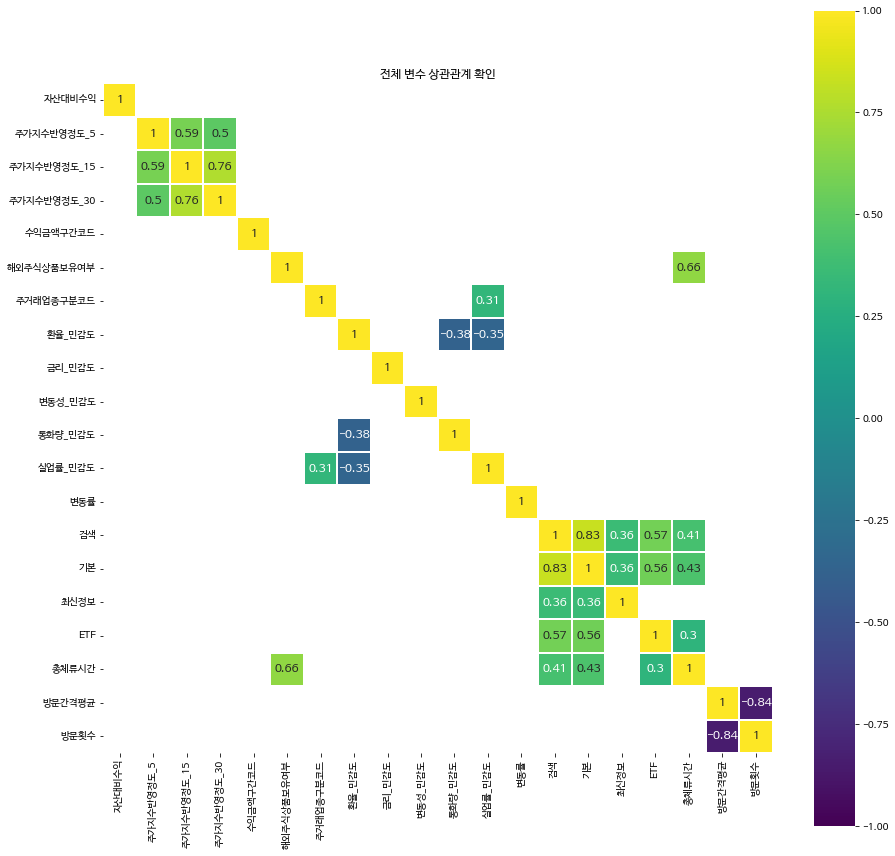

In [ ]:
# 필요한 변수만을 추출
var = ['자산대비수익', '주가지수반영정도_5','주가지수반영정도_15', '주가지수반영정도_30', '수익금액구간코드', 
                    '해외주식상품보유여부', '주거래업종구분코드',
                    '환율_민감도', '금리_민감도', '변동성_민감도', '통화량_민감도', '실업률_민감도',
                    '변동률', '검색', '기본', '최신정보' , 'ETF', '총체류시간', '방문간격평균', '방문횟수']
df_corr = result[var]

# 상관성 확인을 위해 해외주식상품보유여부를 숫자형으로 변환
ossmap = {'Y':1, 'N':0}
df_corr['해외주식상품보유여부'] = df_corr['해외주식상품보유여부'].map(ossmap)

# 전체 변수 상관성 확인
plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(15, 15))
corr = df_corr.corr(method = 'spearman')
sns.heatmap(corr[(corr >= 0.3) | (corr <= -0.3)], cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 12}, square=True);
plt.title('전체 변수 상관관계 확인')

In [ ]:
# 최종 변수만을 포함하는 데이터셋 생성(투자간격 별로 데이터셋을 나누기 위해 '기본주식거래유형코드' 포함)
df_result = result[['자산대비수익', '주가지수반영정도_5','주가지수반영정도_15', '주가지수반영정도_30', '수익금액구간코드', 
                    '해외주식상품보유여부', '주거래업종구분코드', '기본주식거래유형코드', '기간유형',
                    '환율_민감도', '금리_민감도', '변동성_민감도', '변동률', '최신정보' , 'ETF', '방문간격평균']]
df_cusno = result[['계좌번호']]

서로 상관성이 존재하는 ['검색', '기본', '최신정보', 'ETF', '총체류시간']사이에서는 ['검색', '기본', '총체류시간']을 삭제하였고, 이를 삭제함으로써 '해외주식상품보유여부'에 대한 상관성도 모두 해결이 되었다.  
['방문간격평균', '방문횟수'] 중에서는 '방문횟수'를 삭제하였고,  
['환율_민감도', '통화량_민감도', '실업률_민감도'] 사이에서는 ['통화량_민감도', '실업률_민감도'] 두개의 변수를 삭제해 '주거래업종구분코드' 사이와의 상관성도 해결하였다.  
마지막으로 ['주가지수반영정도_5', '주가지수반영정도_10', '주가지수반영정도_15'] 사이의 상관성이 남았는데, 이들은 투자기간 유형에 따라 다르게 적용될 변수이기에 세 개를 모두 살렸다.

## 3.4 K-Prototypes를 활용한 군집분석

선택된 변수들은 범주형과 연속형이 모두 존재하는 혼합형 데이터다.  
**그렇기에 혼합형 데이터에 대한 군집화를 수행할 수 있는 K-Prototypes 알고리즘을 군집분석의 방법으로 선택했다.**  
K-Prototypes는 연속형 변수를 다루는 K-means 알고리즘과 범주형 변수를 다루는 K-Modes 알고리즘을 동시에 활용하는 모형이다. 연속형 변수에 대해서는 유클리디언 거리를 계산하고, 범주형 변수에 대해서는 비유사도를 계산한 다음 비유사도에 가중치를 두어 거리 함수를 제안한다. 데이터와 각 중심점 사이의 거리를 계산해 가장 가까운 군집으로 데이터를 할당시키고, 중심점을 갱신하며 군집화를 수행하는 과정은 여타 군집화 알고리즘과 동일하다.

In [ ]:
# 범주형 변수 정의
df_result = df_result.astype({'수익금액구간코드':'object', '주거래업종구분코드':'object', '최신정보':'float', 'ETF':'float'})

In [ ]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4659 entries, 0 to 4658
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   자산대비수익       4659 non-null   float64
 1   주가지수반영정도_5   4659 non-null   float64
 2   주가지수반영정도_15  4659 non-null   float64
 3   주가지수반영정도_30  4659 non-null   float64
 4   수익금액구간코드     4659 non-null   object 
 5   해외주식상품보유여부   4659 non-null   object 
 6   주거래업종구분코드    4659 non-null   object 
 7   기본주식거래유형코드   4659 non-null   int64  
 8   기간유형         4659 non-null   object 
 9   환율_민감도       4659 non-null   float64
 10  금리_민감도       4659 non-null   float64
 11  변동성_민감도      4659 non-null   float64
 12  변동률          4659 non-null   float64
 13  최신정보         4659 non-null   float64
 14  ETF          4659 non-null   float64
 15  방문간격평균       4659 non-null   float64
dtypes: float64(11), int64(1), object(4)
memory usage: 618.8+ KB


In [ ]:
df_result.columns

Index(['자산대비수익', '주가지수반영정도_5', '주가지수반영정도_15', '주가지수반영정도_30', '수익금액구간코드',
       '해외주식상품보유여부', '주거래업종구분코드', '기본주식거래유형코드', '기간유형', '환율_민감도', '금리_민감도',
       '변동성_민감도', '변동률', '최신정보', 'ETF', '방문간격평균'],
      dtype='object')

In [ ]:
df_num_result = df_result[['자산대비수익', '주가지수반영정도_5','주가지수반영정도_15', '주가지수반영정도_30', 
                    '환율_민감도', '금리_민감도', '변동성_민감도', '변동률', '최신정보' , 'ETF', '방문간격평균']]
scaler = MinMaxScaler()
scaler.fit(df_num_result)
df_num_scaled_result = pd.DataFrame(scaler.transform(df_num_result), columns = df_num_result.columns).reset_index(drop=True)
df_num_scaled_result

,자산대비수익,주가지수반영정도_5,주가지수반영정도_15,주가지수반영정도_30,환율_민감도,금리_민감도,변동성_민감도,변동률,최신정보,ETF,방문간격평균
0,0.854562,0.400742,0.520879,0.503554,0.265734,0.357143,0.118012,8.490372e-10,0.0,0.000000,0.036510
1,0.851942,0.506195,1.000000,1.000000,0.825100,0.392857,0.063665,1.258660e-09,0.0,0.000000,0.003300
2,0.852117,0.367353,0.401230,0.368823,0.111855,0.160714,0.260611,2.851104e-10,0.0,0.000000,1.000000
3,0.878754,0.268590,0.360189,0.547480,0.221030,0.107143,0.186335,1.228768e-09,0.0,0.000000,0.007967
4,0.851384,0.297575,0.359279,0.292954,0.171887,0.170000,0.220310,8.705525e-10,0.0,0.000000,0.006646
...,...,...,...,...,...,...,...,...,...,...,...
4654,0.853585,0.378123,0.390640,0.293203,0.441143,0.233333,0.524068,1.517622e-09,0.0,0.015152,0.004564
4655,0.849261,0.373356,0.424940,0.398080,0.208588,0.214286,0.247768,6.319632e-11,0.0,0.000000,0.001763
4656,0.908074,0.509693,0.446804,0.640730,0.068127,0.107143,0.181677,1.805956e-09,0.0,0.000000,0.000559
4657,0.863790,0.348141,0.373062,0.334351,0.236247,0.146617,0.340471,9.880890e-10,0.0,0.000000,0.005759


In [ ]:
df_num_scaled_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4659 entries, 0 to 4658
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   자산대비수익       4659 non-null   float64
 1   주가지수반영정도_5   4659 non-null   float64
 2   주가지수반영정도_15  4659 non-null   float64
 3   주가지수반영정도_30  4659 non-null   float64
 4   환율_민감도       4659 non-null   float64
 5   금리_민감도       4659 non-null   float64
 6   변동성_민감도      4659 non-null   float64
 7   변동률          4659 non-null   float64
 8   최신정보         4659 non-null   float64
 9   ETF          4659 non-null   float64
 10  방문간격평균       4659 non-null   float64
dtypes: float64(11)
memory usage: 400.5 KB


In [ ]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4659 entries, 0 to 4658
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   자산대비수익       4659 non-null   float64
 1   주가지수반영정도_5   4659 non-null   float64
 2   주가지수반영정도_15  4659 non-null   float64
 3   주가지수반영정도_30  4659 non-null   float64
 4   수익금액구간코드     4659 non-null   object 
 5   해외주식상품보유여부   4659 non-null   object 
 6   주거래업종구분코드    4659 non-null   object 
 7   기본주식거래유형코드   4659 non-null   int64  
 8   기간유형         4659 non-null   object 
 9   환율_민감도       4659 non-null   float64
 10  금리_민감도       4659 non-null   float64
 11  변동성_민감도      4659 non-null   float64
 12  변동률          4659 non-null   float64
 13  최신정보         4659 non-null   float64
 14  ETF          4659 non-null   float64
 15  방문간격평균       4659 non-null   float64
dtypes: float64(11), int64(1), object(4)
memory usage: 618.8+ KB


In [ ]:
df_code_result = df_result[['수익금액구간코드', '해외주식상품보유여부', '주거래업종구분코드', '기본주식거래유형코드', '기간유형']].reset_index(drop=True)
df_result = pd.concat([df_num_scaled_result, df_code_result], axis=1)

In [ ]:
df_result

,자산대비수익,주가지수반영정도_5,주가지수반영정도_15,주가지수반영정도_30,환율_민감도,금리_민감도,변동성_민감도,변동률,최신정보,ETF,방문간격평균,수익금액구간코드,해외주식상품보유여부,주거래업종구분코드,기본주식거래유형코드,기간유형
0,0.854562,0.400742,0.520879,0.503554,0.265734,0.357143,0.118012,8.490372e-10,0.0,0.000000,0.036510,1,N,16.0,5,중장기
1,0.851942,0.506195,1.000000,1.000000,0.825100,0.392857,0.063665,1.258660e-09,0.0,0.000000,0.003300,1,N,16.0,5,중장기
2,0.852117,0.367353,0.401230,0.368823,0.111855,0.160714,0.260611,2.851104e-10,0.0,0.000000,1.000000,1,N,16.0,5,중장기
3,0.878754,0.268590,0.360189,0.547480,0.221030,0.107143,0.186335,1.228768e-09,0.0,0.000000,0.007967,1,N,16.0,5,중장기
4,0.851384,0.297575,0.359279,0.292954,0.171887,0.170000,0.220310,8.705525e-10,0.0,0.000000,0.006646,1,N,16.0,5,중장기
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4654,0.853585,0.378123,0.390640,0.293203,0.441143,0.233333,0.524068,1.517622e-09,0.0,0.015152,0.004564,1,Y,16.0,5,중장기
4655,0.849261,0.373356,0.424940,0.398080,0.208588,0.214286,0.247768,6.319632e-11,0.0,0.000000,0.001763,1,N,5.0,5,중장기
4656,0.908074,0.509693,0.446804,0.640730,0.068127,0.107143,0.181677,1.805956e-09,0.0,0.000000,0.000559,1,N,16.0,5,중장기
4657,0.863790,0.348141,0.373062,0.334351,0.236247,0.146617,0.340471,9.880890e-10,0.0,0.000000,0.005759,1,N,16.0,5,중장기


In [ ]:
# '기본주식거래유형코드' 기준으로 투자 간격 별 고객 1차 분류
df_short = df_result[df_result['기간유형']=='단기'].reset_index(drop = True).drop(['기본주식거래유형코드', '기간유형'], axis = 1)
df_mid = df_result[df_result['기간유형']=='중장기'].reset_index(drop = True).drop(['기본주식거래유형코드', '기간유형'], axis = 1)
df_long = df_result[df_result['기간유형']=='장기'].reset_index(drop = True).drop(['기본주식거래유형코드', '기간유형'], axis = 1)

In [ ]:
# '기본주식거래유형코드' 기준으로 투자 간격 별 고객 1차 분류
#df_short = df_result[(df_result['기본주식거래유형코드']=='001') | (df_result['기본주식거래유형코드']=='002') | (df_result['기본주식거래유형코드']=='003') | (df_result['기본주식거래유형코드']=='004')].reset_index(drop = True).drop(['기본주식거래유형코드'], axis = 1)
#df_mid = df_result[(df_result['기본주식거래유형코드']=='005') | (df_result['기본주식거래유형코드']=='009')].reset_index(drop = True).drop(['기본주식거래유형코드'], axis = 1)
#df_long = df_result[(df_result['기본주식거래유형코드']=='006') | (df_result['기본주식거래유형코드']=='010')].reset_index(drop = True).drop(['기본주식거래유형코드'], axis = 1)

In [ ]:
# 각 기간별 사용하지 않는 주가지수반영정도 컬럼 제거하기
df_short = df_short.drop(['주가지수반영정도_15', '주가지수반영정도_30'], axis=1)
df_mid = df_mid.drop(['주가지수반영정도_5', '주가지수반영정도_30'], axis=1)
df_long = df_long.drop(['주가지수반영정도_5', '주가지수반영정도_15'], axis=1)

### 3.4.1 단기 고객 군집화

#### 최적의 클러스터 개수 탐색

비용함수에 대한 plot을 그려 elbow point를 보이는 자리를 최적의 군집개수로 예측한다.

Categorical columns           : ['수익금액구간코드', '해외주식상품보유여부', '주거래업종구분코드']
Categorical columns position  : [9, 10, 11]


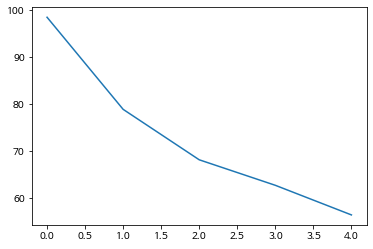

In [ ]:
# 범주형 변수의 자리 가져오기
catColumnsPos = [df_short.columns.get_loc(col) for col in list(df_short.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(df_short.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

# 최적의 군집개수(k) 정하기: 비용함수에서 elbow point를 최적의 군집개수로 결정 
cost = []
for num_clusters in list(range(1,6)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(df_short, categorical=catColumnsPos)
    cost.append(kproto.cost_)

plt.plot(cost)

#### 클러스터 fitting

In [ ]:
dfMatrix = df_short.to_numpy()

kprototype = KPrototypes(n_jobs = -1, n_clusters = 2, init = 'Cao', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([1, 0, 0, ..., 0, 1, 1], dtype=uint16)

In [ ]:
# 클러스터 변수 추가
df_short['cluster_id'] = kprototype.labels_ 

#### 클러스터 별 시각화

**군집 수**

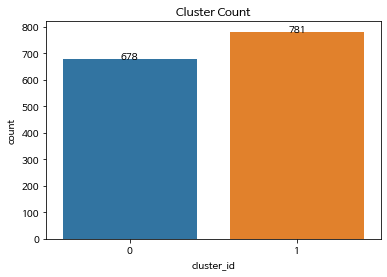

In [ ]:
ax=sns.countplot(x=df_short.cluster_id)
for index, row in pd.DataFrame(df_short['cluster_id'].value_counts()).iterrows():
    ax.text(index,row.values[0], str(round(row.values[0])),color='black', ha="center")
plt.title('Cluster Count')
plt.show()

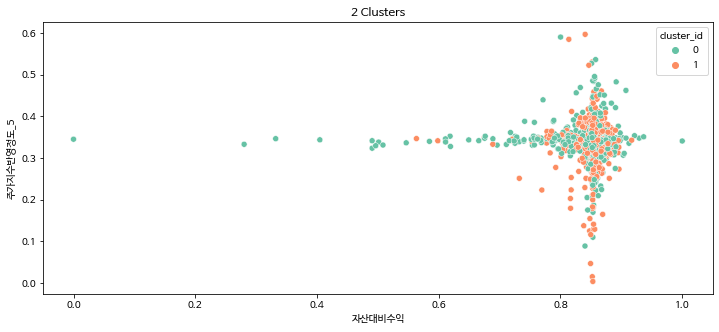

In [ ]:
plt.figure(figsize=(12,5))
sns.scatterplot(x=df_short['자산대비수익'],y=df_short['주가지수반영정도_5'],hue=df_short.cluster_id, palette="Set2",)
plt.title('2 Clusters')
plt.show()

**자산대비수익, 각종 민감도**  
숫자가 클수록 각각 자산대비수익이 높고, 여러 지표에 대해 민감하다고 해석 가능하다.

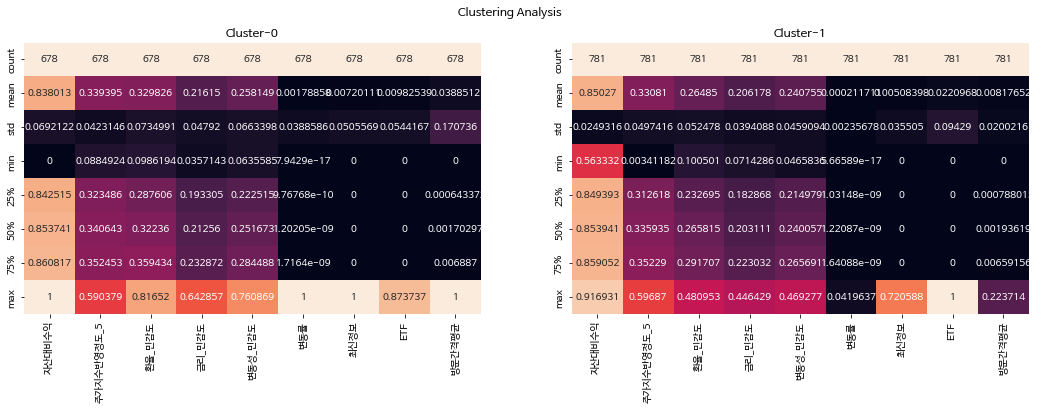

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(18,5))
for cluster_val in sorted(df_short.cluster_id.unique()):
    sns.heatmap(df_short.loc[df_short.cluster_id==cluster_val,['자산대비수익', '주가지수반영정도_5', '환율_민감도', '금리_민감도', '변동성_민감도', '변동률', '최신정보', 'ETF', '방문간격평균']].describe(),annot=True,fmt='g',ax=ax[cluster_val],\
               cbar= 0,vmin=0, vmax=1)
    titl='Cluster-'+str(cluster_val)
    ax[cluster_val].set_title(titl)
plt.suptitle('Clustering Analysis')

plt.show()

거의 모든 변수들에 대해 0.01 사이에서 평균값의 차이가 나타난다.  
다만 각 변수들의 75%값에서 cluster0의 값이 높은 것으로 보아 cluster0에 극한의 민감도를 보이는 고객들이 모여있다는 것을 추론할 수 있다.

**수익금액구간코드**  
숫자가 작을수록 더 작은 수익을 보인다.

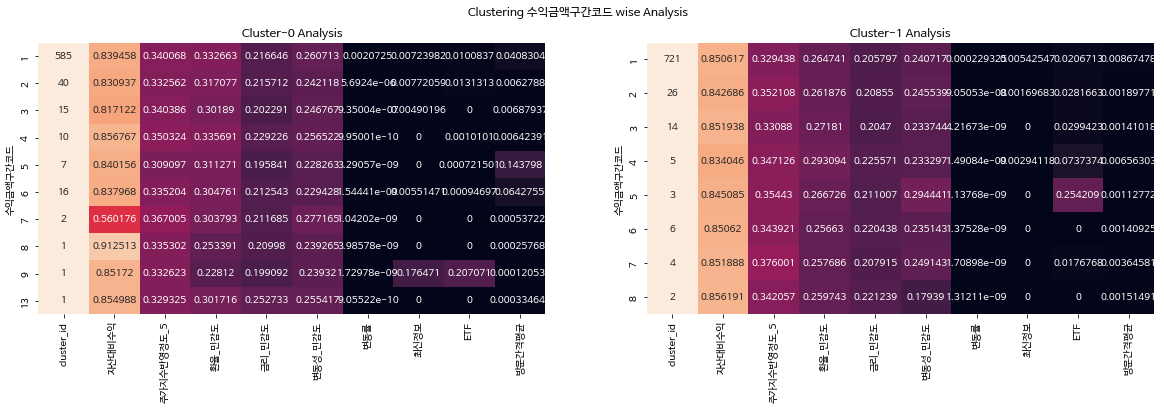

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
for cluster_val in sorted(df_short.cluster_id.unique()): 
    sns.heatmap(df_short.loc[df_short.cluster_id==cluster_val].groupby('수익금액구간코드').agg({'cluster_id':'size','자산대비수익':'mean','주가지수반영정도_5':'mean',
                                                                                       '환율_민감도':'mean', '금리_민감도':'mean', '변동성_민감도':'mean', '변동률':'mean',
                                                                                        '최신정보':'mean', 'ETF':'mean', '방문간격평균':'mean'})
                .fillna(0),annot=True,fmt='g',ax=ax[cluster_val],cbar= 0,vmin=0, vmax=1)
    titl='Cluster-'+str(cluster_val)+' Analysis'
    ax[cluster_val].set_title(titl)

plt.suptitle('Clustering 수익금액구간코드 wise Analysis')
plt.show()

거의 모든 고객이 1.0에 해당하므로, 유의미한 결과를 내기 어렵다.

**해외주식상품보유여부**  
Y는 해외주식상품을 보유하고 있다, N은 보유하고 있지 않다.

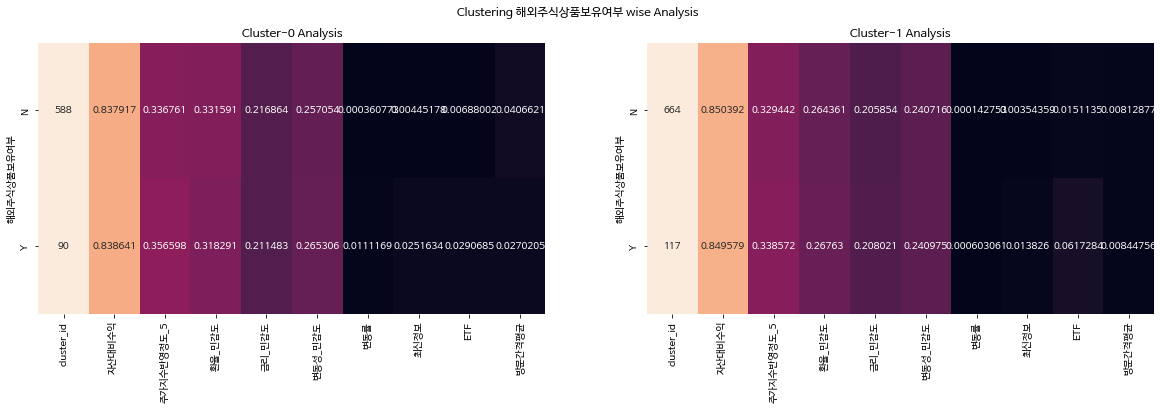

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
for cluster_val in sorted(df_short.cluster_id.unique()): 
    sns.heatmap(df_short.loc[df_short.cluster_id==cluster_val].groupby('해외주식상품보유여부').agg({'cluster_id':'size','자산대비수익':'mean','주가지수반영정도_5':'mean',
                                                                                       '환율_민감도':'mean', '금리_민감도':'mean', '변동성_민감도':'mean', '변동률':'mean',
                                                                                        '최신정보':'mean', 'ETF':'mean', '방문간격평균':'mean'})
                .fillna(0),annot=True,fmt='g',ax=ax[cluster_val],cbar= 0,vmin=0, vmax=1)
    titl='Cluster-'+str(cluster_val)+' Analysis'
    ax[cluster_val].set_title(titl)

plt.suptitle('Clustering 해외주식상품보유여부 wise Analysis')
plt.show()

해외주식상품 역시 두 cluster 내에 비슷한 비율로 보유하고 있다.

**주거래업종구분코드**  
01 건설업 / 02 금융업 / 03 기계 / 04 방송·통신 / 05 서비스·오락·문화 / 06 운송·운수 / 07 유통 / 08 의료·의약 / 09 전기·전자 / 10 제조 /  
 11 철강 / 12 화학 / 13 IT / 14 기타 / 15 혼합 / 16 비매매 / 

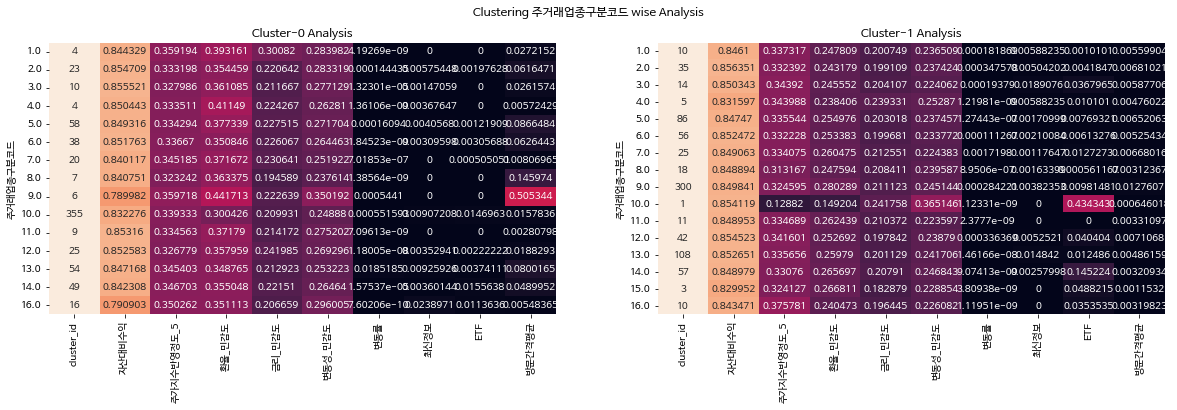

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
for cluster_val in sorted(df_short.cluster_id.unique()): 
    sns.heatmap(df_short.loc[df_short.cluster_id==cluster_val].groupby('주거래업종구분코드').agg({'cluster_id':'size','자산대비수익':'mean','주가지수반영정도_5':'mean',
                                                                                       '환율_민감도':'mean', '금리_민감도':'mean', '변동성_민감도':'mean', '변동률':'mean',
                                                                                        '최신정보':'mean', 'ETF':'mean', '방문간격평균':'mean'})
                .fillna(0),annot=True,fmt='g',ax=ax[cluster_val],cbar= 0,vmin=0, vmax=1)
    titl='Cluster-'+str(cluster_val)+' Analysis'
    ax[cluster_val].set_title(titl)

plt.suptitle('Clustering 주거래업종구분코드 wise Analysis')
plt.show()

cluster0: 제조업(10) >> 서비스·오락·문화(05) > IT(13)  
cluster1: 전기·전자(09) >> IT(13) > 서비스·오락·문화(05)

**각 변수 별 클러스터링 영향 정도**   
각 변수가 클러스터링을 진행하는 데에 얼마나 영향을 끼쳤는지 시각적으로 보여준다.

In [ ]:
df_data = df_short.copy().drop('cluster_id', axis=1)
map = {'Y':1, 'N':0}
df_data['해외주식상품보유여부'] = df_data['해외주식상품보유여부'].map(map)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


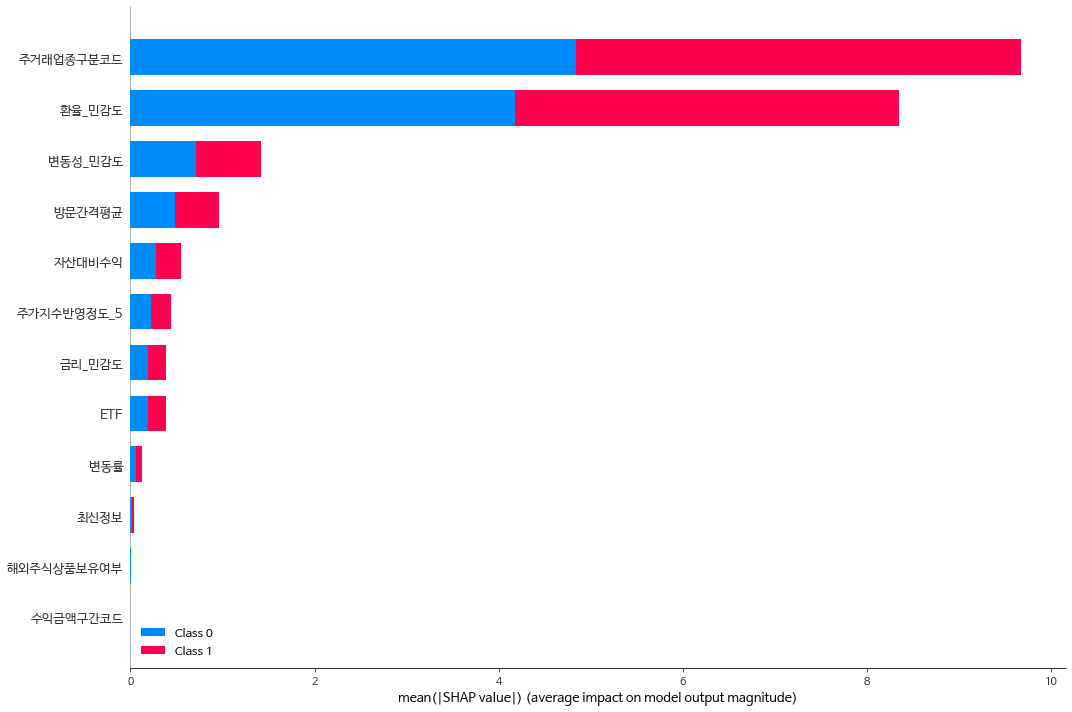

In [ ]:
for c in df_data.select_dtypes(include='object'):
    df_data[c] = df_data[c].astype('int')

clf_kp = LGBMClassifier(colsample_by_tree=0.8)

clf_kp.fit(df_data, kprototype.labels_)
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(df_data)
shap.summary_plot(shap_values_kp, df_data, plot_type="bar", plot_size=(15, 10))

#### 클러스터 평가
LGBM Classifier가 나눈 클러스터와 K-Prototypes가 나눈 클러스터의 교차표를 만들어 F1 score를 산출  
F1 score는 0~1의 값을 가지며 1에 가까울수록 좋은 성능을 보이는 것이라고 판단한다.

In [ ]:
lgbm_data = df_short.copy().drop('cluster_id', axis=1)
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, kprototype.labels_, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Prototypes clusters is 0.9759905278698306


아래는 모두 동일하게 작동한다.

### 3.4.2 중장기 고객 군집화

Categorical columns           : ['수익금액구간코드', '해외주식상품보유여부', '주거래업종구분코드']
Categorical columns position  : [9, 10, 11]


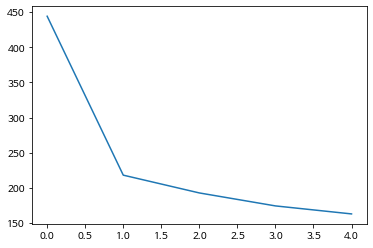

In [ ]:
# 범주형 변수의 자리 가져오기
catColumnsPos = [df_mid.columns.get_loc(col) for col in list(df_mid.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(df_mid.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

# 최적의 클러스터 개수 탐색
cost = []
for num_clusters in list(range(1,6)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(df_mid, categorical=catColumnsPos)
    cost.append(kproto.cost_)

plt.plot(cost)

In [ ]:
# 클러스터 fitting
dfMatrix = df_mid.to_numpy()

kprototype = KPrototypes(n_jobs = -1, n_clusters =3 , init = 'Cao', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([2, 0, 1, ..., 2, 2, 2], dtype=uint16)

In [ ]:
# 클러스터 변수 추가
df_mid['cluster_id'] = kprototype.labels_ 

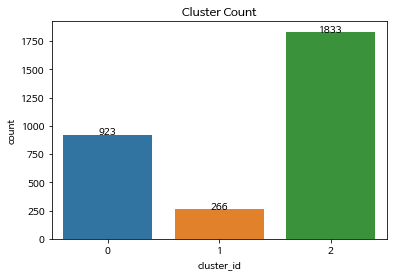

In [ ]:
ax=sns.countplot(x=df_mid.cluster_id)
for index, row in pd.DataFrame(df_mid['cluster_id'].value_counts()).iterrows():
    ax.text(index,row.values[0], str(round(row.values[0])),color='black', ha="center")
    #print(index,row.values[0])
plt.title('Cluster Count')
plt.show()

**자산대비수익, 각종 민감도**  

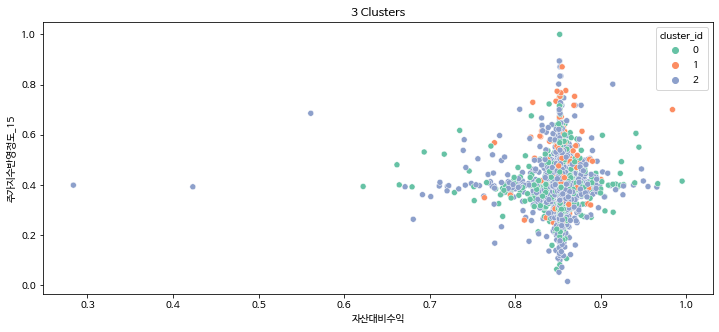

In [ ]:
plt.figure(figsize=(12,5))
sns.scatterplot(x=df_mid['자산대비수익'],y=df_mid['주가지수반영정도_15'],hue=df_mid.cluster_id, palette="Set2",)
plt.title('3 Clusters')
plt.show()

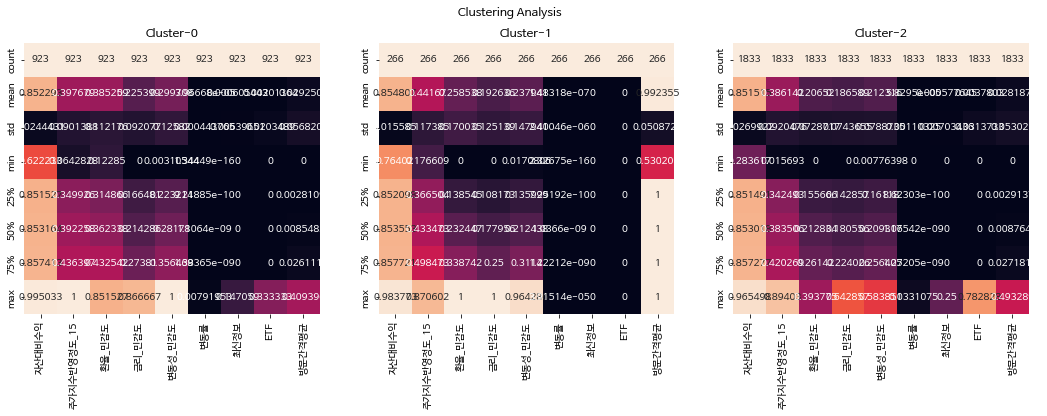

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(18,5))
for cluster_val in sorted(df_mid.cluster_id.unique()):
    sns.heatmap(df_mid.loc[df_mid.cluster_id==cluster_val,['자산대비수익', '주가지수반영정도_15', '환율_민감도', '금리_민감도', '변동성_민감도', '변동률', '최신정보', 'ETF', '방문간격평균']].describe(),annot=True,fmt='g',ax=ax[cluster_val],\
               cbar= 0,vmin=0, vmax=1)
    titl='Cluster-'+str(cluster_val)
    ax[cluster_val].set_title(titl)
plt.suptitle('Clustering Analysis')

plt.show()

cluster1의 고객들은 나머지 두 클러스터에 비해 긴 방문간격을 보인다.  
cluster2의 고객들은 나머지 두 클러스터에 비해 환율, 금리 변동성에 덜 민감한 경향을 보인다.

**수익금액구간코드**

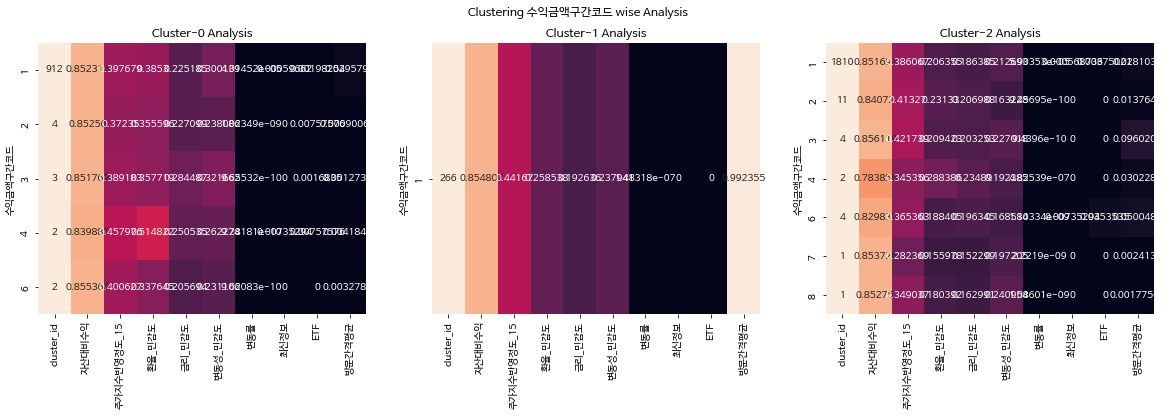

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(20,5))
for cluster_val in sorted(df_mid.cluster_id.unique()): 
    sns.heatmap(df_mid.loc[df_mid.cluster_id==cluster_val].groupby('수익금액구간코드').agg({'cluster_id':'size','자산대비수익':'mean','주가지수반영정도_15':'mean',
                                                                                       '환율_민감도':'mean', '금리_민감도':'mean', '변동성_민감도':'mean', '변동률':'mean',
                                                                                        '최신정보':'mean', 'ETF':'mean', '방문간격평균':'mean'})
                .fillna(0),annot=True,fmt='g',ax=ax[cluster_val],cbar= 0,vmin=0, vmax=1)
    titl='Cluster-'+str(cluster_val)+' Analysis'
    ax[cluster_val].set_title(titl)

plt.suptitle('Clustering 수익금액구간코드 wise Analysis')
plt.show()

거의 모든 고객의 수익금액코드가 1.0에 해당하기에 유의한 결과해석이 어렵다.

**해외주식상품보유여부**

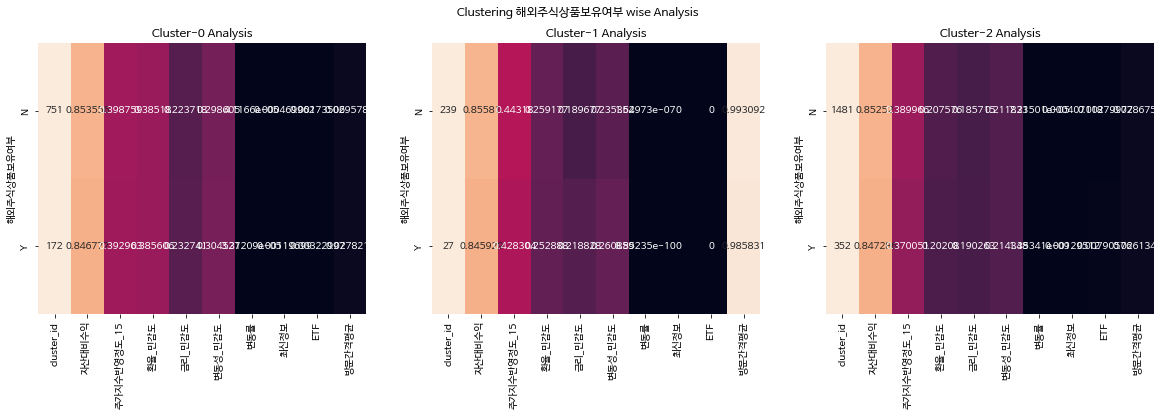

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(20,5))
for cluster_val in sorted(df_mid.cluster_id.unique()): 
    sns.heatmap(df_mid.loc[df_mid.cluster_id==cluster_val].groupby('해외주식상품보유여부').agg({'cluster_id':'size','자산대비수익':'mean','주가지수반영정도_15':'mean',
                                                                                       '환율_민감도':'mean', '금리_민감도':'mean', '변동성_민감도':'mean', '변동률':'mean',
                                                                                        '최신정보':'mean', 'ETF':'mean', '방문간격평균':'mean'})
                .fillna(0),annot=True,fmt='g',ax=ax[cluster_val],cbar= 0,vmin=0, vmax=1)
    titl='Cluster-'+str(cluster_val)+' Analysis'
    ax[cluster_val].set_title(titl)

plt.suptitle('Clustering 해외주식상품보유여부 wise Analysis')
plt.show()

각 cluster별로 해외주식을 보유한 고객의 비율은 19%, 10%, 19%로 cluster1에 해당하는 고객들의 해외주식보유비율이 낮다.

**주거래업종구분코드**

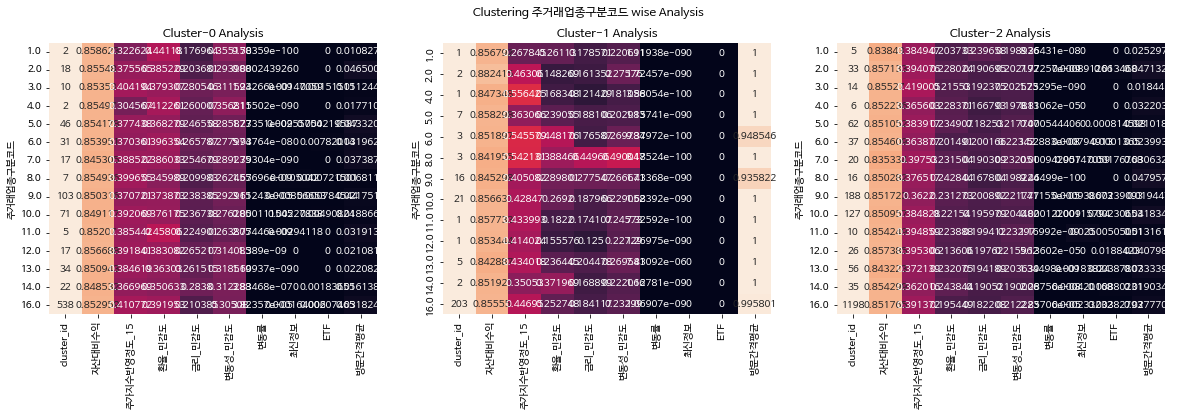

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(20,5))
for cluster_val in sorted(df_mid.cluster_id.unique()): 
    sns.heatmap(df_mid.loc[df_mid.cluster_id==cluster_val].groupby('주거래업종구분코드').agg({'cluster_id':'size','자산대비수익':'mean','주가지수반영정도_15':'mean',
                                                                                       '환율_민감도':'mean', '금리_민감도':'mean', '변동성_민감도':'mean', '변동률':'mean',
                                                                                        '최신정보':'mean', 'ETF':'mean', '방문간격평균':'mean'})
                .fillna(0),annot=True,fmt='g',ax=ax[cluster_val],cbar= 0,vmin=0, vmax=1)
    titl='Cluster-'+str(cluster_val)+' Analysis'
    ax[cluster_val].set_title(titl)

plt.suptitle('Clustering 주거래업종구분코드 wise Analysis')
plt.show()

비매매(16)을 제외하고 세 cluster 모두 전기·전자(09)와 제조(10)의 개수가 높다.

**각 변수 별 클러스터링 영향 정도** 

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


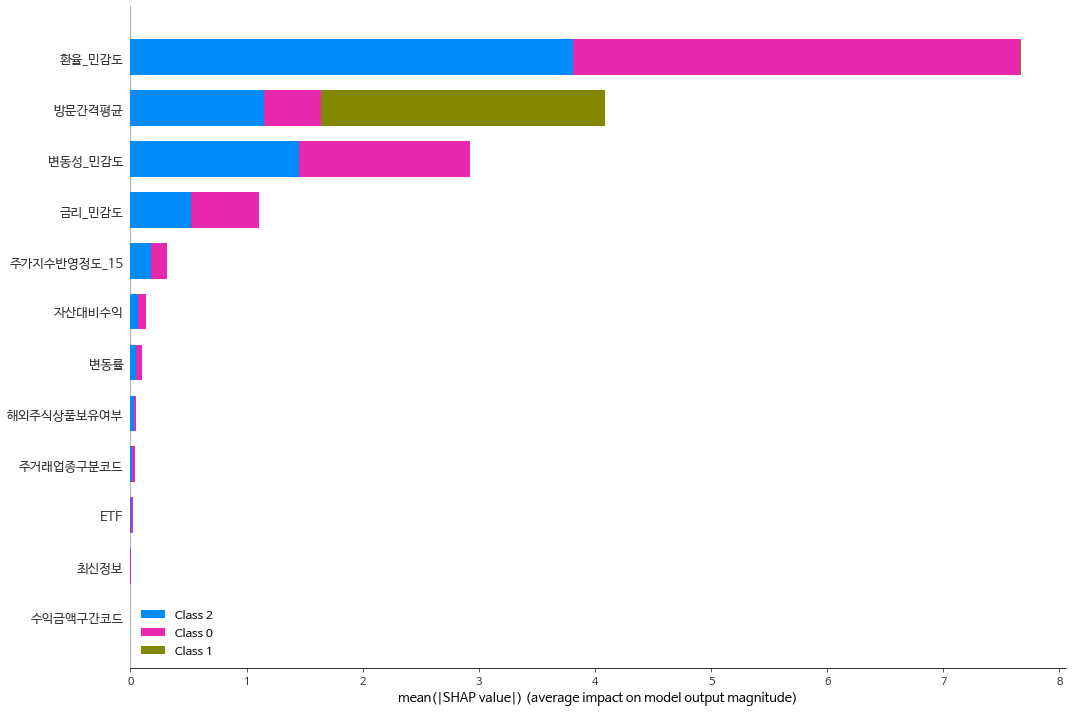

In [ ]:
# 각 변수 별 영향 정도 시각화
df_data = df_mid.copy().drop('cluster_id', axis=1)
map = {'Y':1, 'N':0}
df_data['해외주식상품보유여부'] = df_data['해외주식상품보유여부'].map(map)

for c in df_data.select_dtypes(include='object'):
    df_data[c] = df_data[c].astype('int')

clf_kp = LGBMClassifier(colsample_by_tree=0.8)

clf_kp.fit(df_data, kprototype.labels_)
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(df_data)
shap.summary_plot(shap_values_kp, df_data, plot_type="bar", plot_size=(15, 10))

In [ ]:
# 클러스터 평가
lgbm_data = df_mid.copy().drop('cluster_id', axis=1)
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, kprototype.labels_, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Prototypes clusters is 0.9811396845061509


### 3.4.3 장기 고객 군집화

Categorical columns           : ['수익금액구간코드', '해외주식상품보유여부', '주거래업종구분코드']
Categorical columns position  : [9, 10, 11]


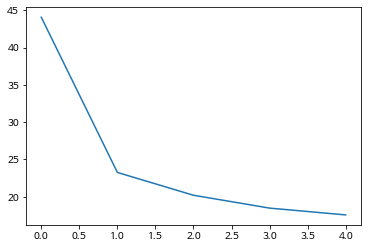

In [ ]:
# 범주형 변수의 자리 가져오기
catColumnsPos = [df_long.columns.get_loc(col) for col in list(df_long.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(df_long.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

# 최적의 클러스터 개수 탐색
cost = []
for num_clusters in list(range(1,6)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(df_long, categorical=catColumnsPos)
    cost.append(kproto.cost_)

plt.plot(cost)

In [ ]:
# 클러스터 fitting
dfMatrix = df_long.to_numpy()

kprototype = KPrototypes(n_jobs = -1, n_clusters =3 , init = 'Cao', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0,
       0, 0, 2, 0, 2, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 2, 2, 1, 2,
       0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 1, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0,
       0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2,
       0, 0, 0, 2, 1, 1, 2, 1, 2, 2, 1, 1, 0, 2, 0, 1, 1, 0, 0, 2, 0, 0,
       0, 1, 0, 2, 1, 1, 0, 0, 1, 1, 2, 0, 1, 0, 2, 0, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 1, 2, 0, 0,
       0, 2, 0, 1, 0, 2, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 2, 2, 0, 0, 1,
       0, 1], dtype=uint16)

In [ ]:
# 클러스터 변수 추가
df_long['cluster_id'] = kprototype.labels_ 

**자산대비수익, 각종 민감도**

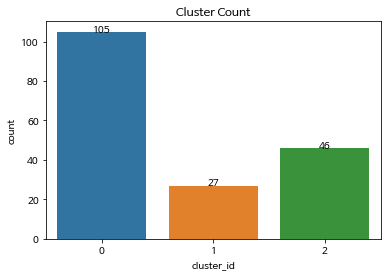

In [ ]:
ax=sns.countplot(x=df_long.cluster_id)
for index, row in pd.DataFrame(df_long['cluster_id'].value_counts()).iterrows():
    ax.text(index,row.values[0], str(round(row.values[0])),color='black', ha="center")
    #print(index,row.values[0])
plt.title('Cluster Count')
plt.show()

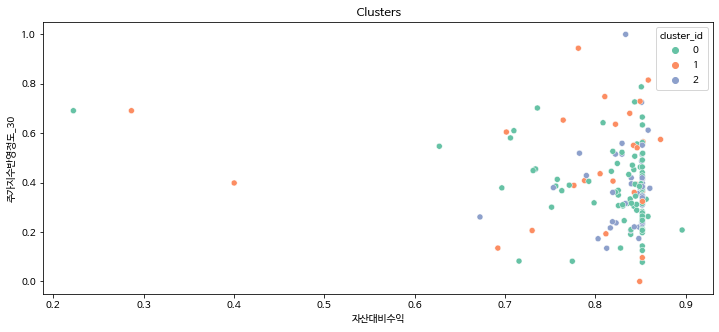

In [ ]:
plt.figure(figsize=(12,5))
sns.scatterplot(x=df_long['자산대비수익'],y=df_long['주가지수반영정도_30'],hue=df_long.cluster_id, palette="Set2",)
plt.title(' Clusters')
plt.show()

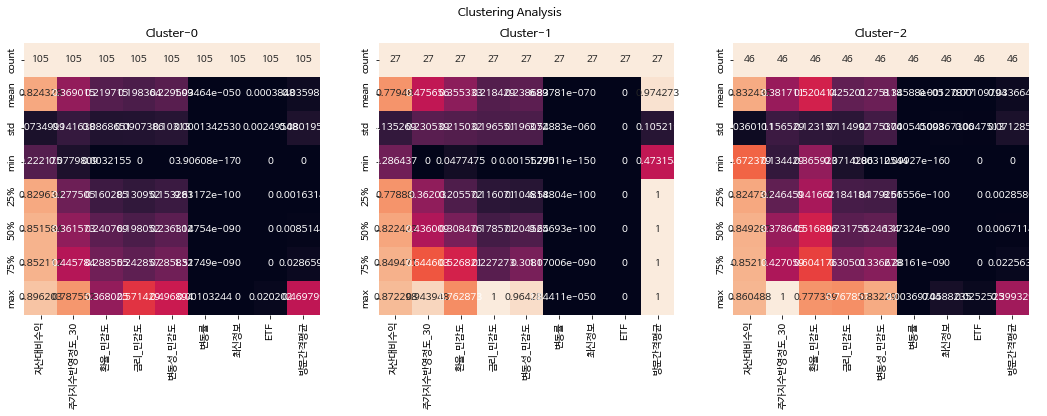

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(18,5))
for cluster_val in sorted(df_long.cluster_id.unique()):
    sns.heatmap(df_long.loc[df_long.cluster_id==cluster_val,['자산대비수익', '주가지수반영정도_30', '환율_민감도', '금리_민감도', '변동성_민감도', '변동률', '최신정보', 'ETF', '방문간격평균']].describe(),annot=True,fmt='g',ax=ax[cluster_val],\
               cbar= 0,vmin=0, vmax=1)
    titl='Cluster-'+str(cluster_val)
    ax[cluster_val].set_title(titl)
plt.suptitle('Clustering Analysis')

plt.show()

cluster0에 해당하는 고객들은 나머지 두 클러스터에 비해 환율과 변동성, 금리에 덜 민감한 모습을 보인다.  
cluster1에 해당하는 고객은 다른 두 클러스터에 비해 긴 방문간격을 보인다.

**수익금액구간코드**

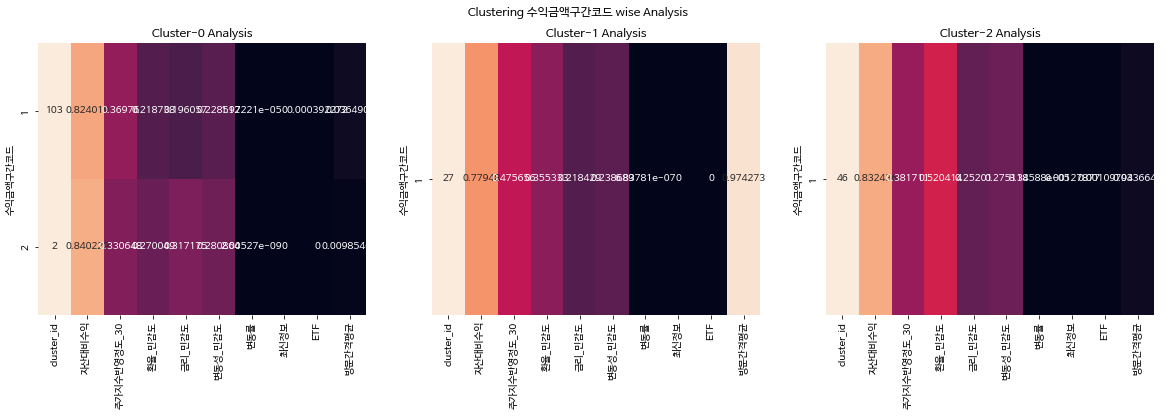

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(20,5))
for cluster_val in sorted(df_long.cluster_id.unique()): 
    sns.heatmap(df_long.loc[df_long.cluster_id==cluster_val].groupby('수익금액구간코드').agg({'cluster_id':'size','자산대비수익':'mean','주가지수반영정도_30':'mean',
                                                                                       '환율_민감도':'mean', '금리_민감도':'mean', '변동성_민감도':'mean', '변동률':'mean',
                                                                                        '최신정보':'mean', 'ETF':'mean', '방문간격평균':'mean'})
                .fillna(0),annot=True,fmt='g',ax=ax[cluster_val],cbar= 0,vmin=0, vmax=1)
    titl='Cluster-'+str(cluster_val)+' Analysis'
    ax[cluster_val].set_title(titl)

plt.suptitle('Clustering 수익금액구간코드 wise Analysis')
plt.show()

대부분의 고객이 1.0에 해당해 유의미한 해석이 어렵다.

**해외주식상품보유여부**

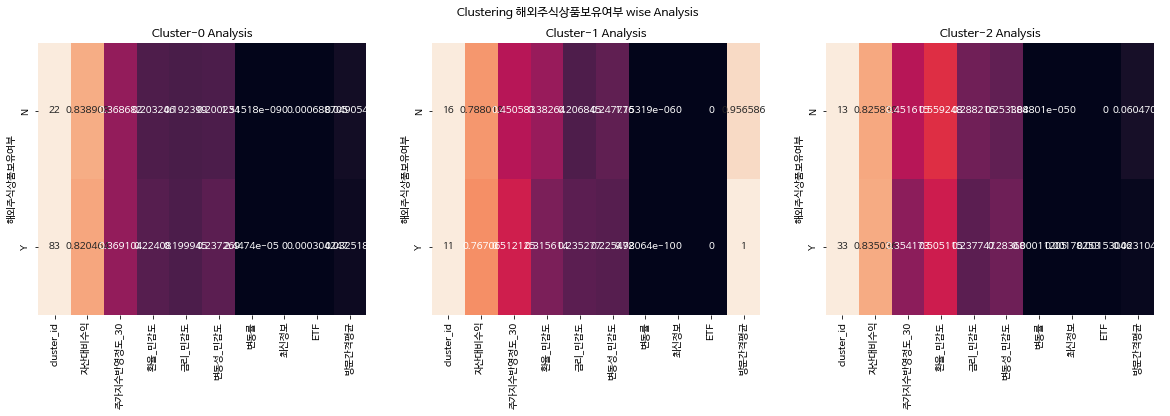

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(20,5))
for cluster_val in sorted(df_long.cluster_id.unique()): 
    sns.heatmap(df_long.loc[df_long.cluster_id==cluster_val].groupby('해외주식상품보유여부').agg({'cluster_id':'size','자산대비수익':'mean','주가지수반영정도_30':'mean',
                                                                                       '환율_민감도':'mean', '금리_민감도':'mean', '변동성_민감도':'mean', '변동률':'mean',
                                                                                        '최신정보':'mean', 'ETF':'mean', '방문간격평균':'mean'})
                .fillna(0),annot=True,fmt='g',ax=ax[cluster_val],cbar= 0,vmin=0, vmax=1)
    titl='Cluster-'+str(cluster_val)+' Analysis'
    ax[cluster_val].set_title(titl)

plt.suptitle('Clustering 해외주식상품보유여부 wise Analysis')
plt.show()

각 cluster에서 해외주식을 보유한 고객의 비율은 80%, 41%, 72%로 clsuter1의 고객들이 해외주식을 덜 보유하고 있다.

**주거래업종구분코드**

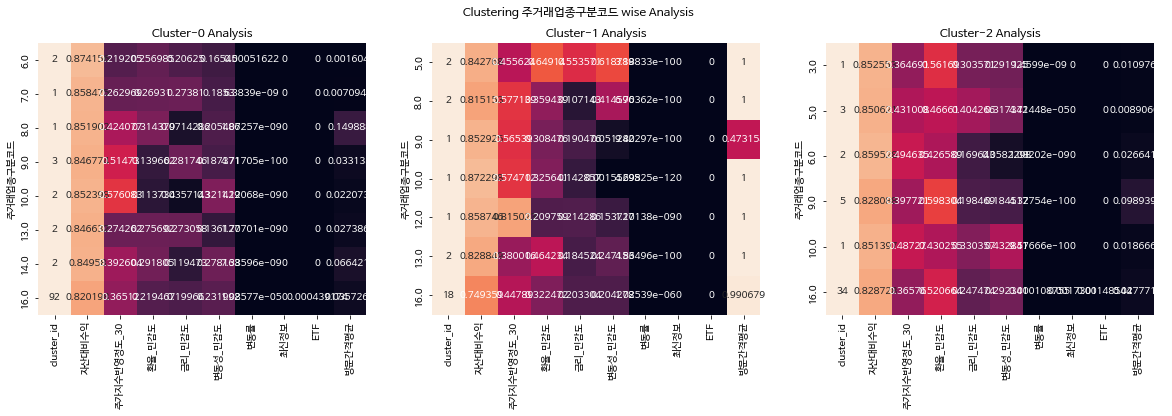

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(20,5))
for cluster_val in sorted(df_long.cluster_id.unique()): 
    sns.heatmap(df_long.loc[df_long.cluster_id==cluster_val].groupby('주거래업종구분코드').agg({'cluster_id':'size','자산대비수익':'mean','주가지수반영정도_30':'mean',
                                                                                       '환율_민감도':'mean', '금리_민감도':'mean', '변동성_민감도':'mean', '변동률':'mean',
                                                                                        '최신정보':'mean', 'ETF':'mean', '방문간격평균':'mean'})
                .fillna(0),annot=True,fmt='g',ax=ax[cluster_val],cbar= 0,vmin=0, vmax=1)
    titl='Cluster-'+str(cluster_val)+' Analysis'
    ax[cluster_val].set_title(titl)

plt.suptitle('Clustering 주거래업종구분코드 wise Analysis')
plt.show()

세 클러스터 모두 비매매(16)의 크기가 가장 크고 나머지 업종에 대한 개수는 눈에 띄게 작으므로, 유의미한 해석이 어렵다.

**각 변수 별 클러스터링 영향 정도**

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


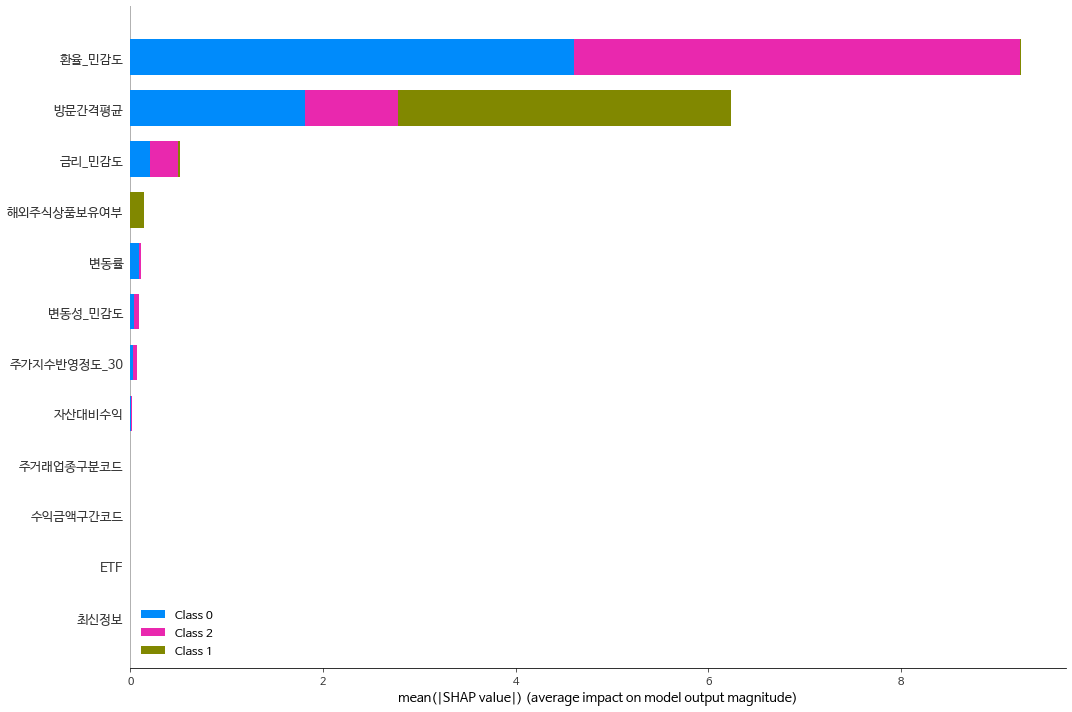

In [ ]:
# 각 변수 별 영향 정도 시각화
df_data = df_long.copy().drop('cluster_id', axis=1)
map = {'Y':1, 'N':0}
df_data['해외주식상품보유여부'] = df_data['해외주식상품보유여부'].map(map)

for c in df_data.select_dtypes(include='object'):
    df_data[c] = df_data[c].astype('int')

clf_kp = LGBMClassifier(colsample_by_tree=0.8)

clf_kp.fit(df_data, kprototype.labels_)
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(df_data)
shap.summary_plot(shap_values_kp, df_data, plot_type="bar", plot_size=(15, 10))

In [ ]:
# 클러스터 평가
lgbm_data = df_long.copy().drop('cluster_id', axis=1)
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, kprototype.labels_, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Prototypes clusters is 0.9886229224895373


# 4. 최종결과

분석 결과를 최종적으로 정리하자면, 투자 간격 별로 도출된 군집들의 투자 성향은 다음과 같다.  

**단기투자 고객군**  
cluster0: 제조업에 주로 투자하며, 환율에 민감하게 반응하는 고객들이 포함되어 있다.  
cluster1: 전기·전자 업종에 주로 투자하며, 각종 지표들에 덜 민감하게 반응한다.  
  
**중장기투자 고객군**  
cluster0: 모든 민감도에 평이하게 반응하며 전기·전자, 제조업에 주로 투자한다.  
cluster1: 긴 방문간격을 가지며, 해외주식에 덜 투자하는 경향을 보인다.  
cluster2: 환율, 금리에 덜 민감한 모습을 보이며 전기·전자, 제조업에 주로 투자한다.  

**장기투자 고객군**  
cluster0: 환율에 덜 민감하게 반응한다.  
cluster1: 긴 방문간격을 가지며, 해외주식에 덜 투자하는 경향을 보인다.  
cluster2: 높은 해외주식상품보유비율을 가지고 있으며, 각종 민감도에 평이하게 반응한다.

### 고객 분류 파일 내보내기

In [ ]:
df_short.to_csv('./temp_data/화이팀_단기투자고객군.csv', encoding="utf-8")
df_mid.to_csv('./temp_data/화이팀_중장기투자고객군.csv', encoding="utf-8")
df_long.to_csv('./temp_data/화이팀_장기투자고객군.csv', encoding="utf-8")